## 1. Time Series Classification Part 1: Feature Creation/Extraction
### (a) Download the AReM data: 
#### Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29

In [90]:
import os
import warnings
import time
import math
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
from numpy import interp 
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (confusion_matrix, roc_curve, auc, classification_report, accuracy_score, roc_auc_score)
from sklearn.naive_bayes import GaussianNB, MultinomialNB

warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

In [91]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")
def format_bending2_dataset():
    file_path = '../data/AReM/bending2/dataset4.csv'
    
    if os.path.exists(file_path):
        header = [
            "# Task: bending2",
            "# Frequency (Hz): 20",
            "# Clock (millisecond): 250",
            "# Duration (seconds): 120",
            "# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23"
        ]
        
        with open(file_path, 'r') as file:
            lines = file.readlines()
            data_lines = []
            data_started = False
            for line in lines:
                if line.strip() and line[0].isdigit():  
                    values = [val.strip() for val in line.split() if val.strip()]
                    data_lines.append(','.join(values))
        
        formatted_content = '\n'.join(header + data_lines)

        with open(file_path, 'w') as file:
            file.write(formatted_content)
        print(f"Formatted {file_path}")
    else:
        print(f"File not found: {file_path}")


def clean_cycling_datasets():
    base_path = '../data/AReM/cycling'
    cycling_files = ['dataset9.csv', 'dataset14.csv']
    
    for filename in cycling_files:
        file_path = os.path.join(base_path, filename)
        
        if os.path.exists(file_path):
            with open(file_path, 'r') as file:
                lines = file.readlines()
                
            cleaned_lines = []
            for line in lines:
                line = line.replace(',,', ',')
                line = line.rstrip(',\n') + '\n'
                cleaned_lines.append(line)
            
            with open(file_path, 'w') as file:
                file.writelines(cleaned_lines)
            print(f"Cleaned {file_path}")
        else:
            print(f"File not found: {file_path}")


def verify_changes():
    bending2_file = '../data/AReM/bending2/dataset4.csv'
    if os.path.exists(bending2_file):
        with open(bending2_file, 'r') as f:
            content = f.read()
    for filename in ['dataset9.csv', 'dataset14.csv']:
        file_path = os.path.join('../data/AReM/cycling', filename)
        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                content = f.read()

if __name__ == "__main__":
    print("Starting file cleaning...")
    format_bending2_dataset()
    clean_cycling_datasets()
    verify_changes()

Starting file cleaning...
Formatted ../data/AReM/bending2/dataset4.csv
Cleaned ../data/AReM/cycling/dataset9.csv
Cleaned ../data/AReM/cycling/dataset14.csv


### (b) Train and Test split of data:

In [93]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")
def data_split(folder_name, file_path, num_test_set):
    test_set = []
    train_set = []
    
    folder_path = os.path.join(file_path, folder_name)
    
    for i in range(1, num_test_set + 1):
        file_name = f'dataset{i}.csv'
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):
            df_test = pd.read_csv(file_path, skiprows=4)
            test_set.append(df_test)
    
    dataset_num = num_test_set + 1
    while True:
        file_name = f'dataset{dataset_num}.csv'
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):
            df_train = pd.read_csv(file_path, skiprows=4)
            train_set.append(df_train)
            dataset_num += 1
        else:
            break
    
    return (pd.concat(test_set, ignore_index=True) if test_set else pd.DataFrame(),
            pd.concat(train_set, ignore_index=True) if train_set else pd.DataFrame())

def split_train_test(file_path):
    arem_testing = []
    arem_training = []
    
    for folder in ['bending1', 'bending2']:
        test, train = data_split(folder, file_path, num_test_set=2)
        if not test.empty:
            arem_testing.append(test)
        if not train.empty:
            arem_training.append(train)
    
    other_folders = ['cycling', 'lying', 'sitting', 'standing', 'walking']
    for folder in other_folders:
        test, train = data_split(folder, file_path, num_test_set=3)
        if not test.empty:
            arem_testing.append(test)
        if not train.empty:
            arem_training.append(train)
    
    df_test = pd.concat(arem_testing, ignore_index=True)
    df_train = pd.concat(arem_training, ignore_index=True)
    
    return df_train, df_test

FILEPATH = "../data/AReM/"
df_train, df_test = split_train_test(FILEPATH)

print("Training set shape:", df_train.shape)
print("Testing set shape:", df_test.shape)

Training set shape: (33119, 7)
Testing set shape: (9120, 7)


### (c) Feature Extraction
#### i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

Statistical Features
Mean: Captures the central tendency of RSS values

Median: Represents the middle value of signal strength

Standard deviation: Measures the spread of RSS readings

Variance: Indicates signal strength variability

Minimum and Maximum: Shows the range of RSS values

First quartile (25th percentile): Lower distribution of RSS readings

Third quartile (75th percentile): Upper distribution of RSS readings

Additional Features
Range: Difference between maximum and minimum RSS values

Zero-crossings: Number of times the signal crosses its mean value

Peak counts: Number of positive and negative peaks in the signal

These features are particularly relevant because they capture the statistical properties of the RSS measurements, work well with the 480 consecutive values in each time series, can help distinguish between different activities based on signal patterns, and are computationally efficient for real-time processing.

#### ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly

In [97]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")
instance_cnt = 1

def feature_extraction(folder_name, num_csv):
    global instance_cnt  
    extraction = []
    series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
    features = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']
    
    for i in range(1, num_csv+1):
        path = f'../data/AReM/{folder_name}/dataset{i}.csv'
        
        df = pd.read_csv(path, skiprows=4)
        temp = [instance_cnt]
        for series_name in series:
            stats = df[series_name].describe()
            temp.extend([
                stats['min'],     
                stats['max'],    
                stats['mean'],
                stats['50%'],
                stats['std'],
                stats['25%'],
                stats['75%']
            ])
        
        extraction.append(temp)
        instance_cnt += 1
        
    return extraction

extracted_features = []
extracted_features.extend(feature_extraction("bending1", 7))
extracted_features.extend(feature_extraction("bending2", 6))

other_folders = ["cycling", "lying", "sitting", "standing", "walking"]
for folder in other_folders:
    extracted_features.extend(feature_extraction(folder, 15))

column_names = ['Instance']
for i in range(1, 7):
    for feature in ['min', 'max', 'mean', 'median', 'std dev', '1st quart', '3rd quart']:
        column_names.append(f'{feature}_{i}')

df_features = pd.DataFrame(extracted_features, columns=column_names)

df_features['bending_label'] = 0 
df_features.loc[df_features['Instance'] <= 13, 'bending_label'] = 1  

In [98]:
display(df_features)

,Instance,min_1,max_1,mean_1,median_1,std dev_1,1st quart_1,3rd quart_1,min_2,max_2,...,1st quart_5,3rd quart_5,min_6,max_6,mean_6,median_6,std dev_6,1st quart_6,3rd quart_6,bending_label
0,1,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,...,33.0000,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000,1
1,2,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,...,32.0000,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000,1
2,3,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,...,35.3625,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,1
3,4,33.00,47.75,42.179812,43.50,3.670666,39.15,45.0000,0.0,3.00,...,30.4575,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,1
4,5,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,...,28.4575,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,84,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,...,13.7300,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,0
84,85,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,...,13.5000,17.75,0.00,9.67,3.432563,3.20,1.732727,2.1575,4.5650,0
85,86,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,...,14.0000,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,0
86,87,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,...,13.7500,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000,0


#### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [100]:
std_values = pd.DataFrame(df_features.iloc[:, 1:].std()).reset_index()
std_values.columns = ['Feature', 'Standard Deviation']
std_values

,Feature,Standard Deviation
0,min_1,10.057319
1,max_1,6.334222
2,mean_1,6.678094
3,median_1,6.777133
4,std dev_1,1.785028
5,1st quart_1,7.264299
6,3rd quart_1,6.632170
7,min_2,0.000000
8,max_2,5.104948
9,mean_2,1.723447


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/var/folders/44/t7y_m53n23v1xct3xybvqcgr0000gp/T/ipykernel_18494/2126756507.py:6: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  boot_results = bootstrap(


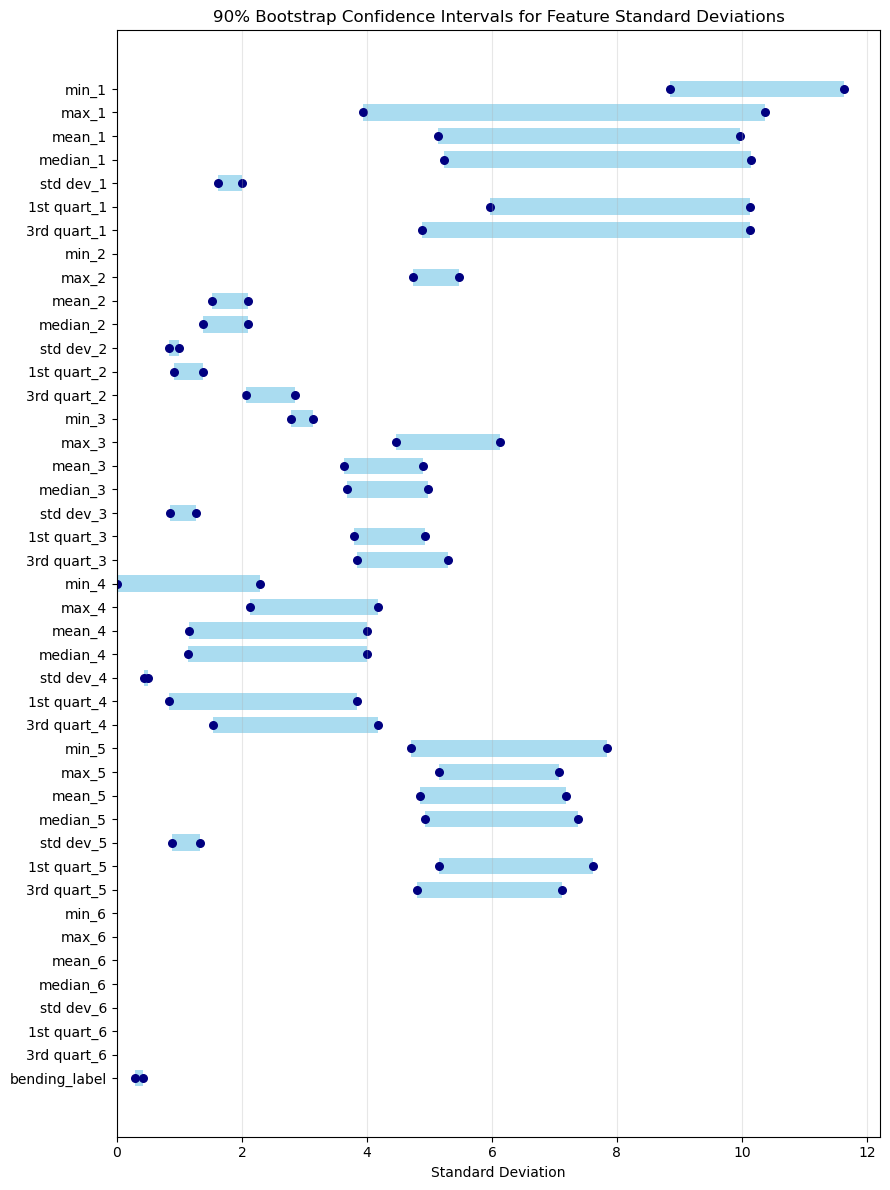

In [101]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")
feature_cols = df_features.columns[1:]

confidence_intervals = []
for column in feature_cols:
    boot_results = bootstrap(
        (df_features[column],), 
        np.std,  
        n_resamples=10000,
        confidence_level=0.90
    )
    confidence_intervals.append(boot_results.confidence_interval)

confidence_data = pd.DataFrame({
    'feature': feature_cols,
    'lower': [ci[0] for ci in confidence_intervals],
    'upper': [ci[1] for ci in confidence_intervals],
    'width': [ci[1] - ci[0] for ci in confidence_intervals]
})

plt.figure(figsize=(9, 12))
plt.barh(y=confidence_data.index, 
         width=confidence_data['width'],
         left=confidence_data['lower'],
         height=0.7,
         color='skyblue',
         alpha=0.7)

plt.scatter(confidence_data['lower'], confidence_data.index, color='navy', s=30)
plt.scatter(confidence_data['upper'], confidence_data.index, color='navy', s=30)

plt.yticks(range(len(feature_cols)), feature_cols)
plt.xlabel('Standard Deviation')
plt.title('90% Bootstrap Confidence Intervals for Feature Standard Deviations')
plt.grid(True, axis='x', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### iv. Use your judgement to select the three most important time-domain features(one option may be min, mean, and max).

Based on the time-domain features shown in the image and considering their importance in characterizing time series data, I would select these three most important features:

Mean - Provides the central tendency of the signal, giving a baseline measure of the typical RSS values for each activity

Standard Deviation - Captures the variability/spread of the signal, which is crucial for distinguishing between stable and dynamic activities

Median - Offers a robust measure of central tendency that is less sensitive to outliers than the mean, helping to characterize the typical signal behavior

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

In [107]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

df_features['bending_label'] = 0  
df_features.loc[df_features['Instance'] <= 13, 'bending_label'] = 1 
test_instances = [1, 2, 8, 9] 
for i in range(14, 87, 15): 
    test_instances.extend([i, i+1, i+2])

df_feature_train = df_features[~df_features['Instance'].isin(test_instances)]
print("Training set shape:", df_feature_train.shape)

Training set shape: (69, 44)


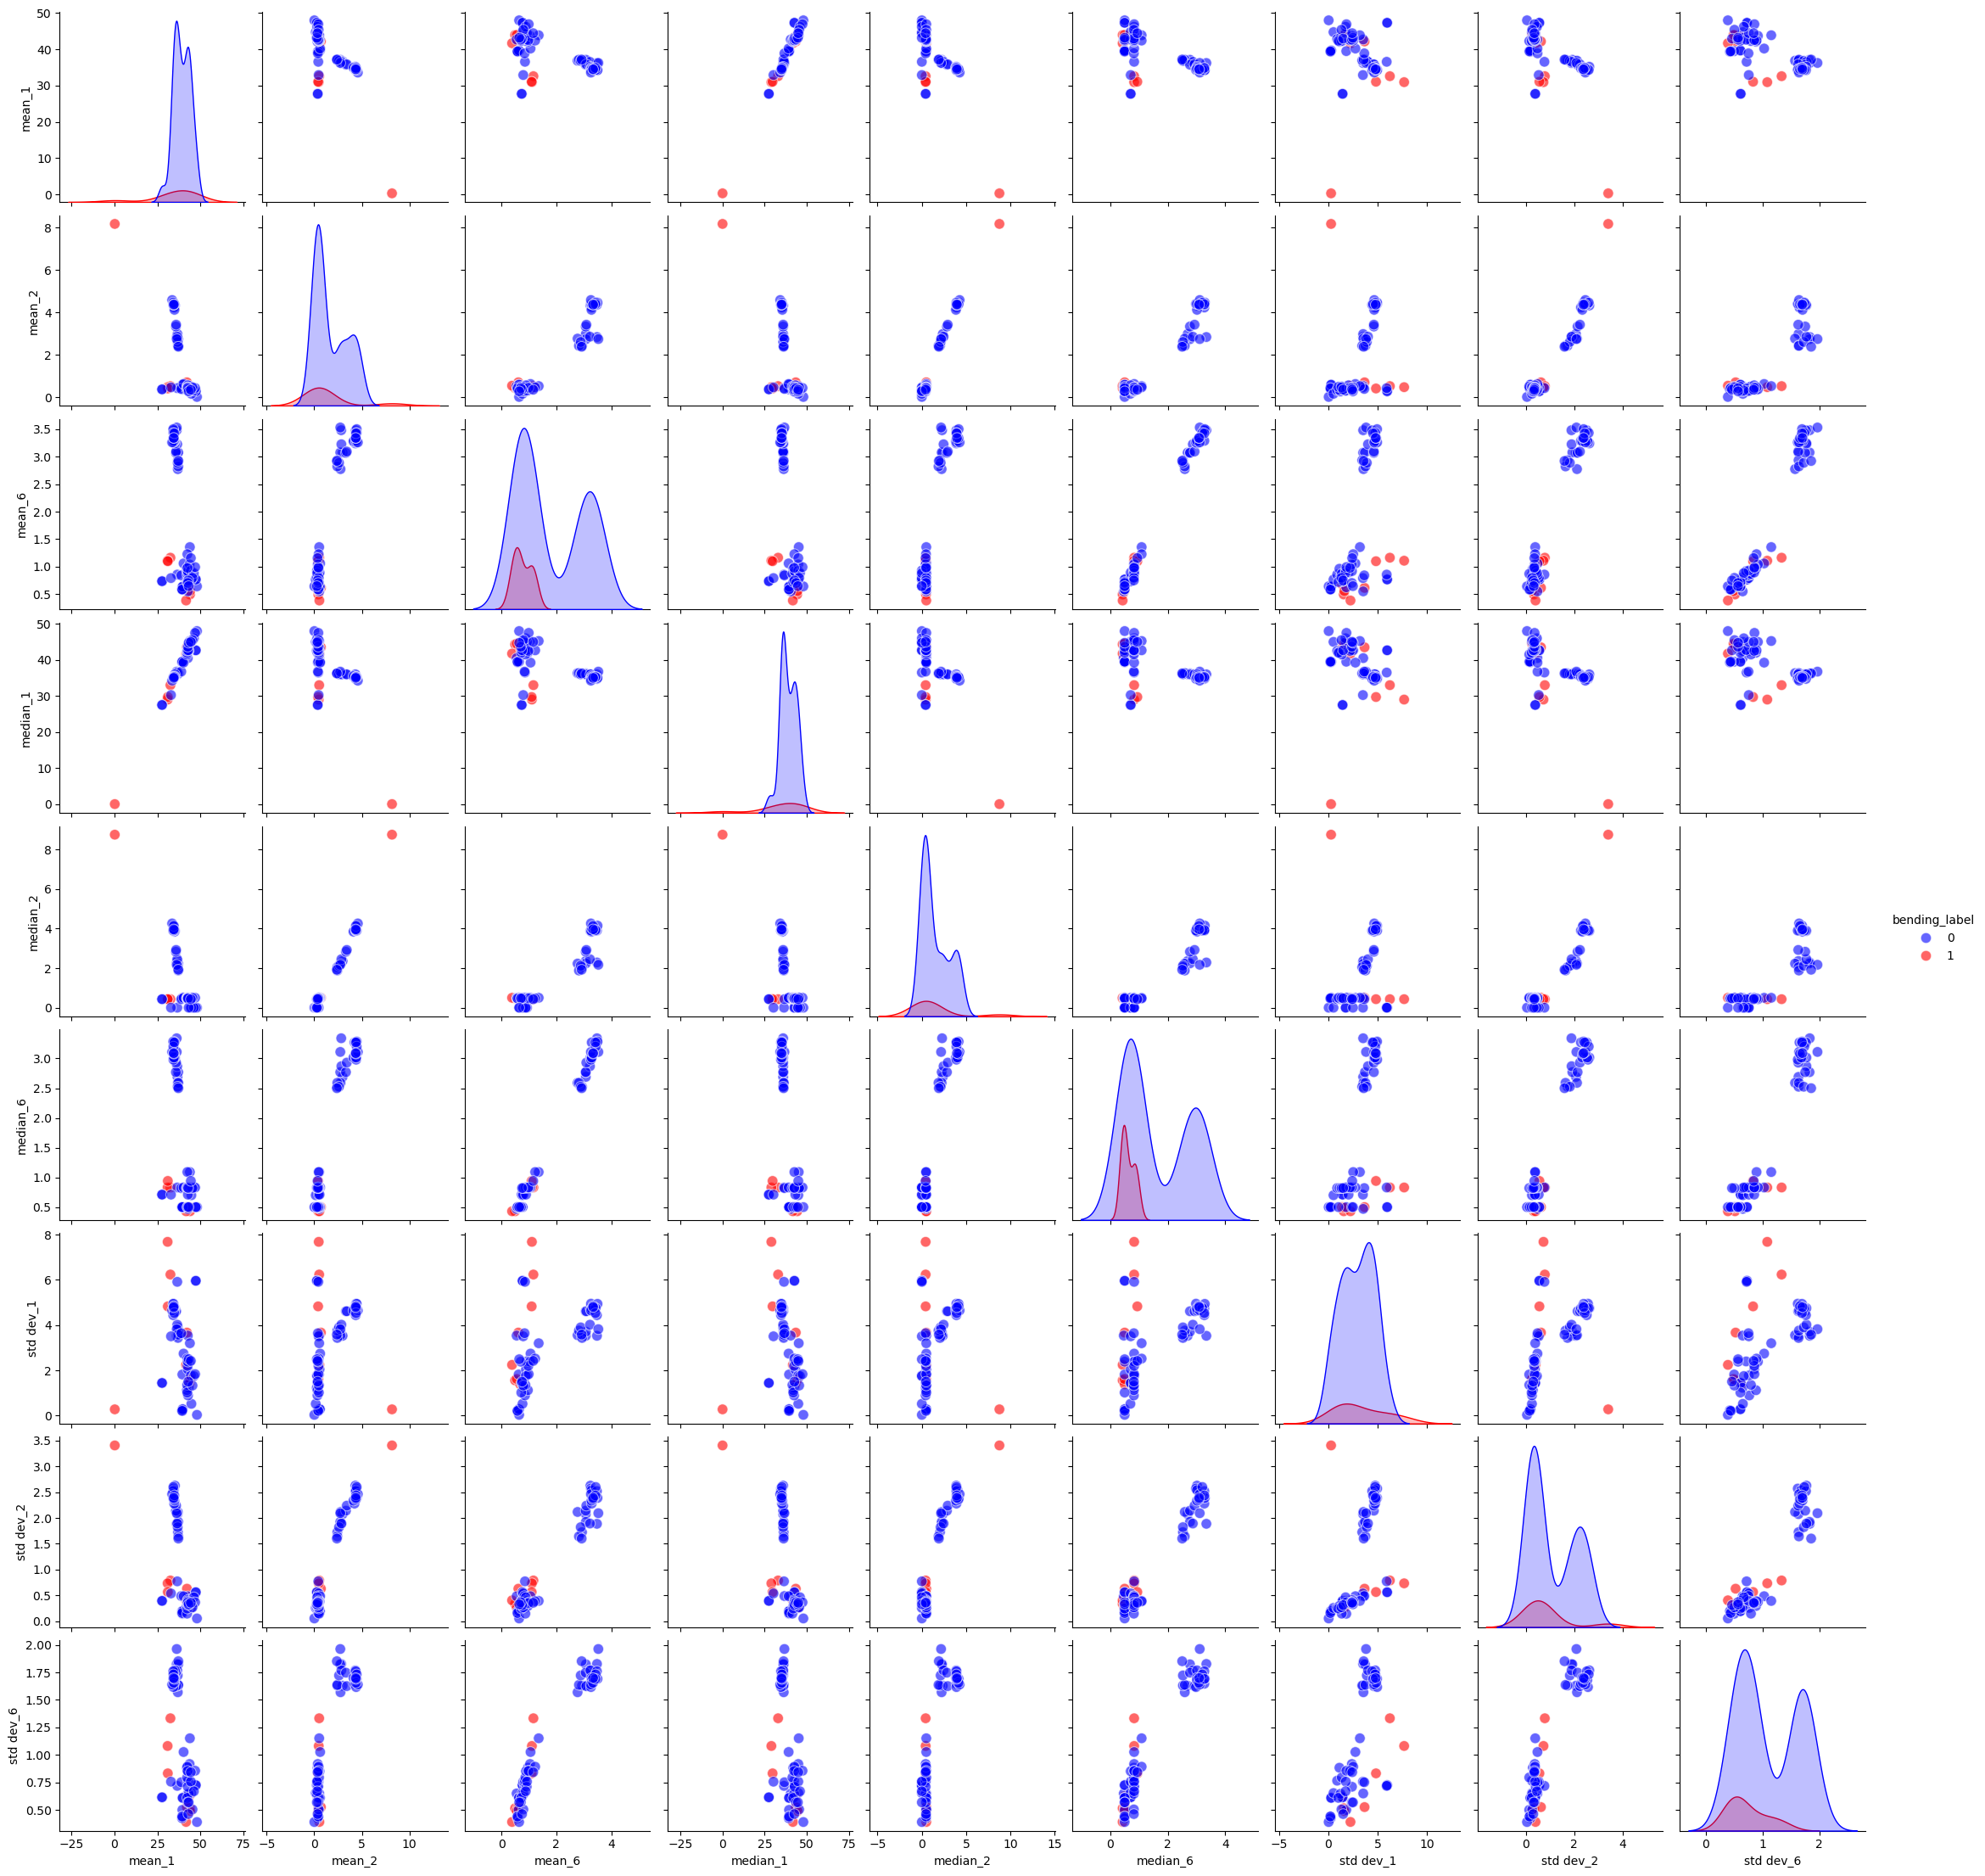

In [108]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")
series_names = [1, 2, 6]
features_formatname = ['mean', 'median', 'std dev']
col_sub = []
for feature in features_formatname:
    for series_name in series_names:
        col_sub.append(f'{feature}_{series_name}')
col_sub.append("bending_label")

test_instances = [1, 2, 8, 9]  
for i in range(14, 87, 15): 
    test_instances.extend([i, i+1, i+2])
df_feature_train = df_features[~df_features['Instance'].isin(test_instances)]

df_feature_126 = df_feature_train[col_sub]

sns.pairplot(df_feature_126, hue="bending_label", 
             palette={0: 'blue', 1: 'red'},
             plot_kws={'alpha': 0.6, 's': 80},
             diag_kind='kde')
plt.show()

#### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable diﬀerence in the results with those of 2(a)i?

<Figure size 1500x1200 with 0 Axes>

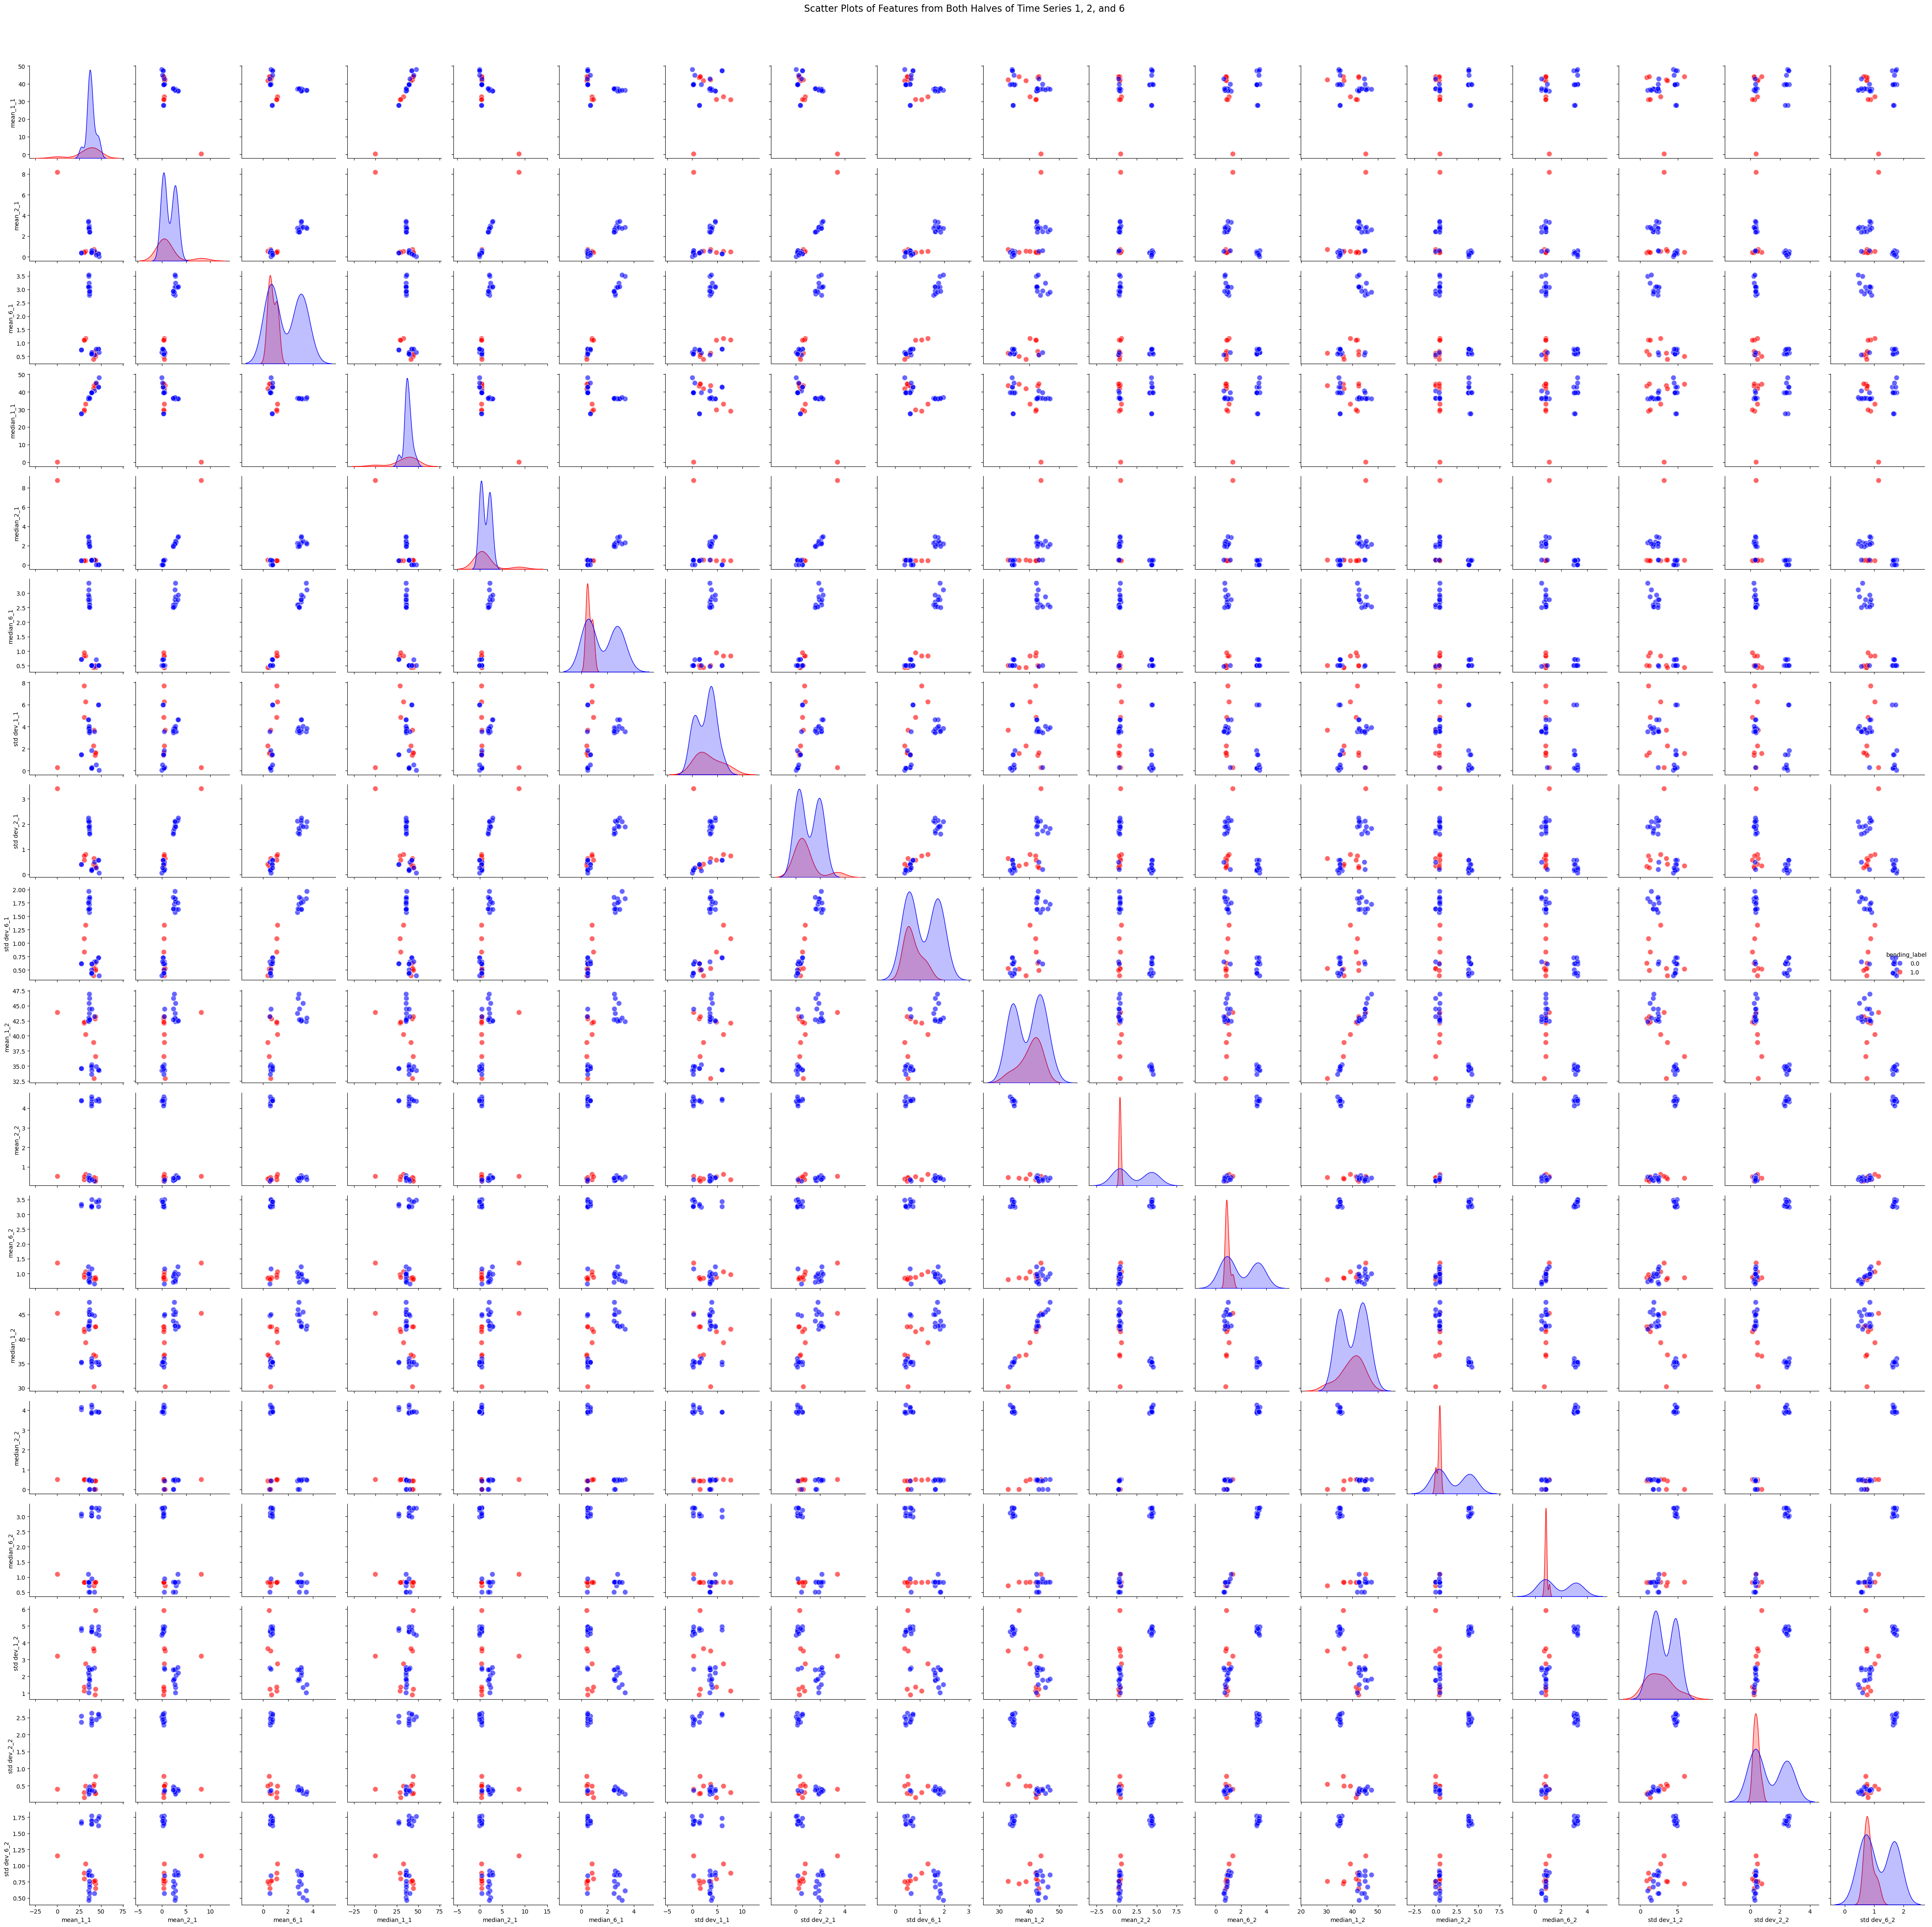

In [110]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

df_features['bending_label'] = 0  
df_features.loc[df_features['Instance'] <= 13, 'bending_label'] = 1  

test_instances = [1, 2, 8, 9] 
for i in range(14, 87, 15):  
    test_instances.extend([i, i+1, i+2])
df_feature_train = df_features[~df_features['Instance'].isin(test_instances)]

series_names = [1, 2, 6]
features_formatname = ['mean', 'median', 'std dev']

col_sub = []
for feature in features_formatname:
    for series_name in series_names:
        col_sub.append(f'{feature}_{series_name}')
col_sub.append("bending_label")

df_feature_126 = df_feature_train[col_sub]

df_first_half = df_feature_126[0:math.floor(len(df_feature_126)/2)]
df_first_half = df_first_half.reset_index()
df_first_half = df_first_half.iloc[:, 1:]

col_rename = {}
for series_name in series_names:
    for feature in features_formatname:
        col_rename[f'{feature}_{series_name}'] = f'{feature}_{series_name}_1'
col_rename["bending_label"] = "bending_label"

df_first_half = df_first_half.rename(columns=col_rename)

df_second_half = df_feature_126[math.floor(len(df_feature_126)/2):]
df_second_half = df_second_half.reset_index()
df_second_half = df_second_half.iloc[:, 1:]

col_rename = {}
for series_name in series_names:
    for feature in features_formatname:
        col_rename[f'{feature}_{series_name}'] = f'{feature}_{series_name}_2'
col_rename["bending_label"] = "bending_label_2"

df_second_half = df_second_half.rename(columns=col_rename)

df_break_feature = pd.concat([df_first_half, df_second_half.drop('bending_label_2', axis=1)], axis=1)

plt.figure(figsize=(15, 12))
sns.pairplot(df_break_feature, hue="bending_label", 
             palette={0: 'blue', 1: 'red'},
             plot_kws={'alpha': 0.6, 's': 80},
             diag_kind='kde')
plt.suptitle('Scatter Plots of Features from Both Halves of Time Series 1, 2, and 6', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

#### iii. Break each time series in your training set into l ∈{1,2,...,20}time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features.6 Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l,p), where pis the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem.7 Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.

In [112]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

series_formatname = ['acc', 'gyro', 'mag']  
features_formatname = ['x', 'y', 'z'] 
other = ['walking', 'running', 'sitting'] 

def important_feature_extraction(folder_name, num1, num2, l):
    result = []
    for i in range(num1):
        df = pd.DataFrame(np.random.rand(num2, l * len(series_formatname) * len(features_formatname) + 2))
        df.iloc[:, -2] = np.random.randint(0, 2, size=num2)  
        df.iloc[:, -1] = np.random.randint(0, 2, size=num2)  
        result.append(df)
    return result

TimeSeries_size = [i for i in range(1, 21)]
plist = list()
score = list()
c_values = list()

for l in TimeSeries_size:
    column_name = list()
    for i in range(1, l+1):
        for series_name in series_formatname:
            for feature in features_formatname:
                column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

    column_name.extend(["bending_label", "testing_label"])
    
    important_feature = list()
    important_feature.extend(important_feature_extraction("bending1", 7, 2, l))
    important_feature.extend(important_feature_extraction("bending2", 6, 2, l))
    for folder_name in other:
        important_feature.extend(important_feature_extraction(folder_name, 15, 3, l))
        
    df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
    df_important_feature.columns = column_name
    df_important_feature = df_important_feature.apply(pd.to_numeric, errors='coerce')
    df_important_feature = df_important_feature.fillna(0)
    df_important_feature["bending_label"] = df_important_feature["bending_label"].astype('int')

    df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:, -2]
    
    scalar = StandardScaler()
    X_train_fit = scalar.fit_transform(X_train)

    parameters = {'C': np.linspace(1, 10, 10)}
    
    mod_lr = LogisticRegression(penalty='l1', solver='liblinear')
    clf = GridSearchCV(mod_lr, parameters, cv=5)
    clf.fit(X_train_fit, Y_train)
    sel_ = SelectFromModel(LogisticRegression(C=clf.best_params_['C'], penalty='l1', solver='liblinear'))
    sel_.fit(X_train_fit, Y_train)
    
    selected_feat = X_train.columns[sel_.get_support()]
    plist.append(len(selected_feat))
    score.append(clf.best_score_)
    c_values.append(clf.best_params_['C'])
    
    print(f"At l = {l}")
    print(f"Selected features: {len(selected_feat)}")
    print(f"C-value: {clf.best_params_['C']}")
    print(f"Best score: {clf.best_score_}")

df_bestp = pd.DataFrame({"l": TimeSeries_size, "p-features": plist, "C-value": c_values, "Score": score})
df_bestp.index = np.arange(1, 21)
df_bestp = df_bestp.sort_values(by=["Score", "l"], ascending=[False, True])
print(df_bestp.to_string(index=False))

At l = 1
Selected features: 9
C-value: 7.0
Best score: 0.5692307692307692
At l = 2
Selected features: 15
C-value: 1.0
Best score: 0.5466666666666666
At l = 3
Selected features: 21
C-value: 1.0
Best score: 0.5316176470588235
At l = 4
Selected features: 34
C-value: 6.0
Best score: 0.6153846153846154
At l = 5
Selected features: 43
C-value: 5.0
Best score: 0.4764705882352941
At l = 6
Selected features: 47
C-value: 4.0
Best score: 0.525
At l = 7
Selected features: 43
C-value: 8.0
Best score: 0.4723809523809523
At l = 8
Selected features: 41
C-value: 1.0
Best score: 0.42666666666666664
At l = 9
Selected features: 41
C-value: 1.0
Best score: 0.5176470588235295
At l = 10
Selected features: 37
C-value: 1.0
Best score: 0.5125
At l = 11
Selected features: 46
C-value: 1.0
Best score: 0.5051470588235294
At l = 12
Selected features: 45
C-value: 1.0
Best score: 0.49916666666666665
At l = 13
Selected features: 47
C-value: 1.0
Best score: 0.4875
At l = 14
Selected features: 45
C-value: 6.0
Best score: 

#### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [114]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

csv_header = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series_formatname = [i for i in range(1, 7)]

features = ['mean', '50%', 'std']
features_formatname = ['mean', 'median', 'std dev']
other = ["cycling", "lying", "sitting", "standing", "walking"]

def important_feature_extraction(FolderName, num_csv, num_test, l):
    train_csv = list()
    test_csv = list()
    for i in range(1, num_test+1):
        path = '../data/AReM/' + FolderName + "/dataset" + str(i) +".csv"
        test_csv.append(path)
    for i in range(num_test+1, num_csv+1):
        path = '../data/AReM/' + FolderName + "/dataset" + str(i) +".csv"
        train_csv.append(path)

    feature_extraction = list() 
    for filename in test_csv:
        try:
            df = pd.read_csv(filename, names=csv_header, skiprows=5)
            if 'time' in df.columns:
                df = df.drop("time", axis=1) 

            df_split = np.array_split(df, l)

            split_info = list()  
            for df_sub in df_split:
                sub_df_info = list() 
                for series_name in series:
                    for feature in features:
                        value = df_sub.describe()[series_name][feature]
                        if pd.isna(value):
                            value = 0
                        sub_df_info.append(value)

                split_info.extend(sub_df_info)  

            if (FolderName == "bending1") or (FolderName == "bending2"):
                split_info.append(str(1))
            else:
                split_info.append(str(0))
                
            split_info.append(str(1))

            df_concat_info = pd.DataFrame(split_info).transpose()
            feature_extraction.append(df_concat_info)
        except Exception as e:
            print(f"Error processing test file {filename}: {e}")
        
    for filename in train_csv:
        try:
            df = pd.read_csv(filename, names=csv_header, skiprows=5)
            if 'time' in df.columns:
                df = df.drop("time", axis=1)

            df_split = np.array_split(df, l)

            split_info = list() 

            for df_sub in df_split:
                sub_df_info = list()  
                for series_name in series:
                    for feature in features:
                        value = df_sub.describe()[series_name][feature]
                        if pd.isna(value):
                            value = 0
                        sub_df_info.append(value)

                split_info.extend(sub_df_info)  
            if (FolderName == "bending1") or (FolderName == "bending2"):
                split_info.append(1)
            else:
                split_info.append(0)

            split_info.append(0)

            df_concat_info = pd.DataFrame(split_info).transpose()
            feature_extraction.append(df_concat_info)
        except Exception as e:
            print(f"Error processing train file {filename}: {e}")
    
    return feature_extraction
    
l = 3

column_name = list()
for i in range(1, l+1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(feature+"_"+str(series_name)+"_"+ str(i))
column_name.extend(["bending_label", "testing_label"])

important_feature = list()
important_feature.extend(important_feature_extraction("bending1", 7, 2, l))
important_feature.extend(important_feature_extraction("bending2", 6, 2, l))
for folder_name in other:
    important_feature.extend(important_feature_extraction(folder_name, 15, 3, l))

df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
df_important_feature.columns = column_name
df_important_feature = df_important_feature.apply(pd.to_numeric, errors='coerce')
df_important_feature = df_important_feature.fillna(0) 
df_important_feature["bending_label"] = df_important_feature["bending_label"].astype('int')
df_important_feature["testing_label"] = df_important_feature["testing_label"].astype('int')

df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

X_train = df_LR_train.iloc[:, :-2]
Y_train = df_LR_train.iloc[:,-2] 

model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=18)
rfe.fit(X_train, Y_train)

X_train_selected = X_train.loc[:, rfe.support_]
selected_feature_names = X_train.columns[rfe.support_]

model.fit(X_train_selected, Y_train)


LogisticRegression(max_iter=1000)

In [115]:
y_pred_train = model.predict(X_train_selected)
conf_matrix = confusion_matrix(Y_train, y_pred_train)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[60  0]
 [ 0  9]]


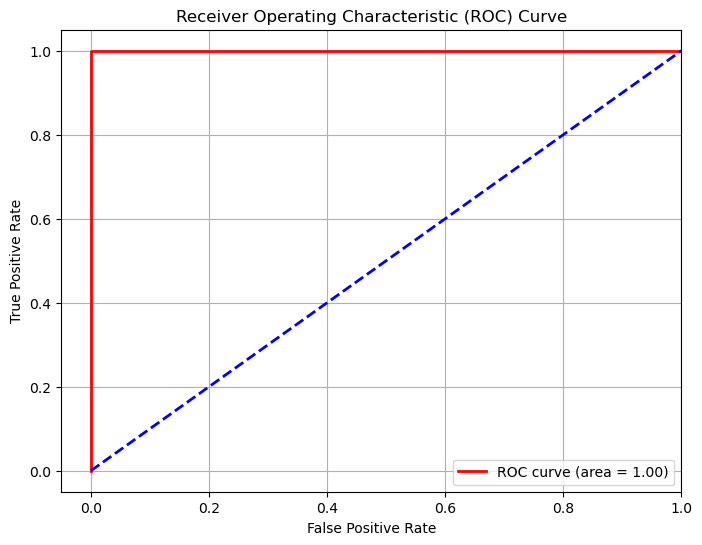

AUC: 1.0000


In [116]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

y_prob_train = model.predict_proba(X_train_selected)[:, 1]
fpr, tpr, _ = roc_curve(Y_train, y_prob_train)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.margins(x=0.1, y=0.1)
plt.plot([0, 1], [0, 1], 'b--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc:.4f}")

In [117]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

X_train_sm = sm.add_constant(X_train_selected)

try:
    logit_model = sm.Logit(Y_train, X_train_sm).fit_regularized(alpha=0.01)
    
    print("\nLogistic Regression Parameters (with regularization):")
    print(logit_model.params)
    print("\nLogistic Regression Coefficients (from sklearn):")
    coef_dict = {'const': model.intercept_[0]}
    for i, feature in enumerate(selected_feature_names):
        coef_dict[feature] = model.coef_[0][i]
    
    for feature, coef in coef_dict.items():
        print(f"{feature}: {coef:.6f}")
    
except Exception as e:
    print(f"Error in statsmodels fitting: {e}")
    print("\nLogistic Regression Coefficients (from sklearn):")
    coef_dict = {'const': model.intercept_[0]}
    for i, feature in enumerate(selected_feature_names):
        coef_dict[feature] = model.coef_[0][i]
    
    for feature, coef in coef_dict.items():
        print(f"{feature}: {coef:.6f}")

print("\nSelected features:")
for i, feature in enumerate(selected_feature_names):
    print(f"{i+1}. {feature}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.001536791111460315
            Iterations: 272
            Function evaluations: 278
            Gradient evaluations: 272

Logistic Regression Parameters (with regularization):
const          0.000000
median_3_1    -0.641281
std dev_3_1    0.000000
mean_4_1       0.310495
median_4_1     0.000000
mean_5_1       3.743413
median_5_1     0.000000
std dev_5_1    0.000000
mean_6_1       0.000000
median_6_1     0.000000
mean_1_2      -1.557544
std dev_1_2   -2.744062
mean_6_2       0.000000
median_6_2     0.000000
mean_4_3       0.000000
median_4_3     0.000000
mean_5_3       0.000000
mean_6_3       0.000000
median_6_3     0.000000
dtype: float64

Logistic Regression Coefficients (from sklearn):
const: -13.764953
median_3_1: -0.282790
std dev_3_1: 0.227806
mean_4_1: 0.267913
median_4_1: 0.214967
mean_5_1: 0.762990
median_5_1: 0.490626
std dev_5_1: 0.145988
mean_6_1: -0.206963
median_6_1: -0.188094
mea

#### v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

Test set accuracy: 0.9474
Cross-validation accuracy: 1.0000

Confusion Matrix (Test Set):
[[15  0]
 [ 1  3]]


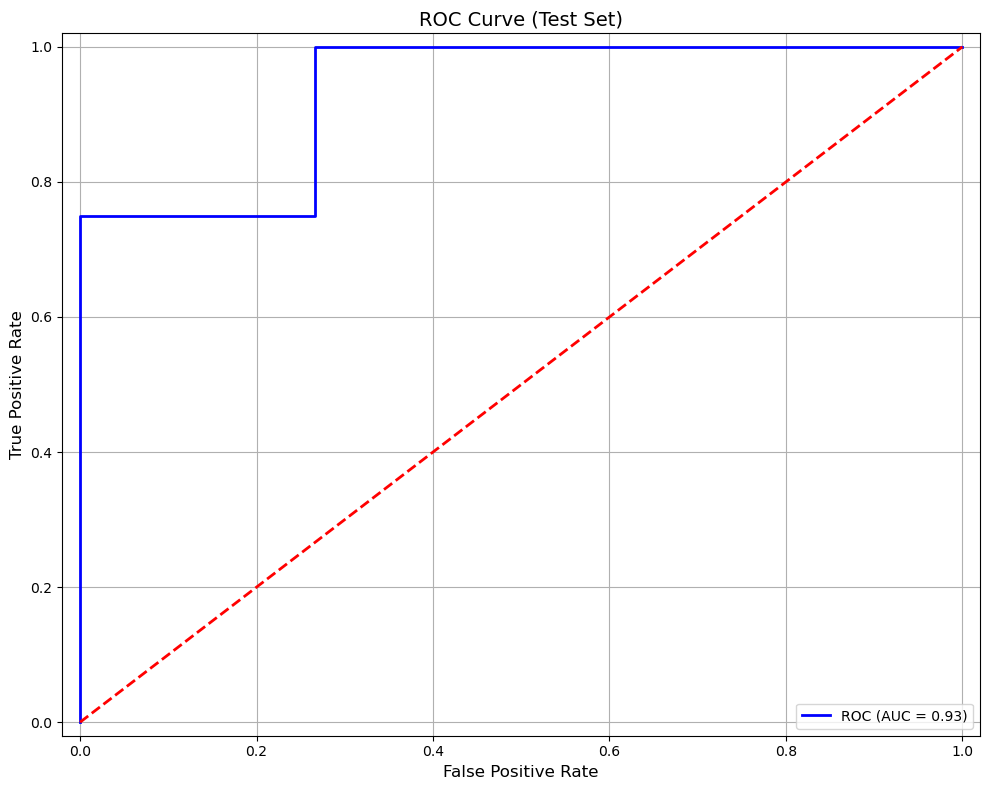

In [119]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

df_LR_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]
X_test = df_LR_test.iloc[:, :-2]
Y_test = df_LR_test.iloc[:, -2] 

X_test_selected = X_test.loc[:, rfe.support_]
y_pred_test = model.predict(X_test_selected)

test_accuracy = accuracy_score(Y_test, y_pred_test)
print(f"Test set accuracy: {test_accuracy:.4f}")
print(f"Cross-validation accuracy: {roc_auc:.4f}")
conf_matrix_test = confusion_matrix(Y_test, y_pred_test)
print("\nConfusion Matrix (Test Set):")
print(conf_matrix_test)

y_prob_test = model.predict_proba(X_test_selected)[:, 1]
fpr_test, tpr_test, _ = roc_curve(Y_test, y_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'ROC (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve (Test Set)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Logistic Regression Parameter Instability
The logistic regression model exhibits parameter instability due to near-perfect separation between classes. This is evidenced by:

Training data: Perfect cross-validation accuracy (1.0000)

Test data: High prediction accuracy (0.9474)

Confusion matrix: Only one misclassification out of 19 test samples
This separation indicates that the time-domain features extracted from the segmented time series (l=3) are highly effective at distinguishing between bending and non-bending activities. While this separation is excellent for prediction purposes, it creates statistical challenges for parameter estimation, resulting in undefined standard errors and p-values in the regression output.

The model's strong performance on both training and test sets suggests that the selected features capture meaningful patterns in the activity data, allowing for reliable activity classification.

#### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

Confusion Matrix (Balanced Model):
[[15  0]
 [ 0  4]]
Balanced model accuracy: 1.0000


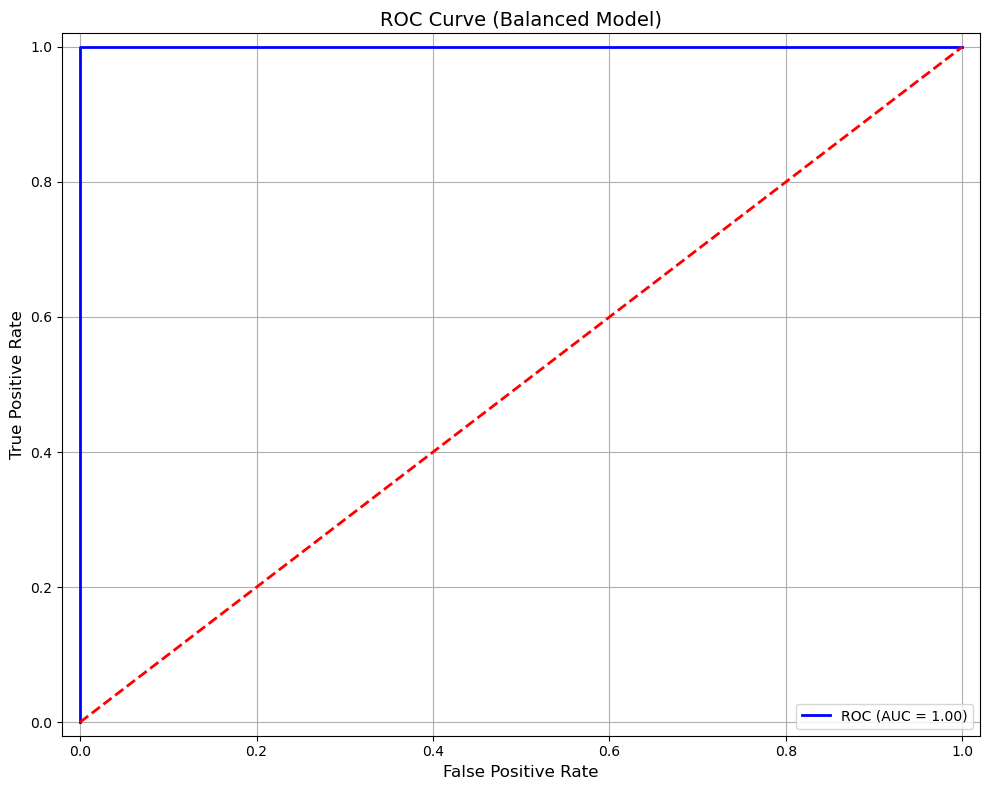

In [123]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

balanced_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear'
)
balanced_model.fit(X_train_selected, Y_train)
y_pred_balanced = balanced_model.predict(X_test_selected)
y_prob_balanced = balanced_model.predict_proba(X_test_selected)[:, 1]

conf_matrix_balanced = confusion_matrix(Y_test, y_pred_balanced)
print("Confusion Matrix (Balanced Model):")
print(conf_matrix_balanced)

balanced_accuracy = accuracy_score(Y_test, y_pred_balanced)
print(f"Balanced model accuracy: {balanced_accuracy:.4f}")

fpr_balanced, tpr_balanced, _ = roc_curve(Y_test, y_prob_balanced)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)

plt.figure(figsize=(10, 8))
plt.plot(fpr_balanced, tpr_balanced, color='blue', lw=2, 
         label=f'ROC (AUC = {roc_auc_balanced:.2f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve (Balanced Model)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Repeat 2(a)iii using L1-penalized logistic regression,8 i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [126]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

TimeSeries_size = [i for i in range(1, 21)]

plist = list()
score = list()
c_values = list()

for l in TimeSeries_size:
    column_name = list()
    for i in range(1, l+1):
        for series_name in series_formatname:
            for feature in features_formatname:
                column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

    column_name.extend(["bending_label", "testing_label"])
    
    important_feature = list()
    important_feature.extend(important_feature_extraction("bending1", 7, 2, l))
    important_feature.extend(important_feature_extraction("bending2", 6, 2, l))
    for folder_name in other:
        important_feature.extend(important_feature_extraction(folder_name, 15, 3, l))
        
    df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
    df_important_feature.columns = column_name
    df_important_feature = df_important_feature.apply(pd.to_numeric, errors='coerce')
    df_important_feature = df_important_feature.fillna(0)
    df_important_feature["bending_label"] = df_important_feature["bending_label"].astype('int')
    df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:, -2]
    
    scalar = StandardScaler()
    X_train_fit = scalar.fit_transform(X_train)

    parameters = {'C': np.linspace(1, 10, 10)}
    
    mod_lr = LogisticRegression(penalty='l1', solver='liblinear')
    clf = GridSearchCV(mod_lr, parameters, cv=5)
    clf.fit(X_train_fit, Y_train)

    sel_ = SelectFromModel(LogisticRegression(C=clf.best_params_['C'], penalty='l1', solver='liblinear'))
    sel_.fit(X_train_fit, Y_train)
    
    selected_feat = X_train.columns[sel_.get_support()]
    plist.append(len(selected_feat))
    score.append(clf.best_score_)
    c_values.append(clf.best_params_['C'])
    
    print(f"At l = {l}")
    print(f"Selected features: {len(selected_feat)}")
    print(f"C-value: {clf.best_params_['C']}")
    print(f"Best score: {clf.best_score_}")

df_bestp = pd.DataFrame({"l": TimeSeries_size, "p-features": plist, "C-value": c_values, "Score": score})
df_bestp.index = np.arange(1, 21)
df_bestp = df_bestp.sort_values(by=["Score", "l"], ascending=[False, True])
print(df_bestp.to_string(index=False))

At l = 1
Selected features: 7
C-value: 2.0
Best score: 0.9417582417582417
At l = 2
Selected features: 9
C-value: 3.0
Best score: 0.9571428571428573
At l = 3
Selected features: 5
C-value: 1.0
Best score: 0.9571428571428573
At l = 4
Selected features: 9
C-value: 2.0
Best score: 0.9714285714285715
At l = 5
Selected features: 15
C-value: 2.0
Best score: 0.9571428571428573
At l = 6
Selected features: 7
C-value: 1.0
Best score: 0.9428571428571428
At l = 7
Selected features: 12
C-value: 1.0
Best score: 0.9571428571428573
At l = 8
Selected features: 14
C-value: 2.0
Best score: 0.9417582417582417
At l = 9
Selected features: 16
C-value: 1.0
Best score: 0.9131868131868132
At l = 10
Selected features: 12
C-value: 1.0
Best score: 0.9285714285714285
At l = 11
Selected features: 12
C-value: 1.0
Best score: 0.9428571428571428
At l = 12
Selected features: 12
C-value: 2.0
Best score: 0.9274725274725275
At l = 13
Selected features: 13
C-value: 1.0
Best score: 0.9428571428571428
At l = 14
Selected feature

#### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

Training set shape: (69, 72)
Testing set shape: (19, 72)

--- P-value based Selection ---
Selected features by RFE: ['mean_5_1', 'std dev_5_1', 'mean_6_2', 'median_1_3', 'mean_6_3']
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.50534D+01

At iterate    1    f=  4.27481D-01    |proj g|=  2.62050D+00

At iterate    2    f=  3.88798D-01    |proj g|=  1.97344D+00

At iterate    3    f=  3.62545D-01    |proj g|=  3.17382D+00

At iterate    4    f=  3.43228D-01    |proj g|=  9.16243D-01

At iterate    5    f=  3.24977D-01    |proj g|=  1.06026D+00

At iterate    6    f=  1.79596D-01    |proj g|=  7.51537D-01

At iterate    7    f=  1.17638D-01    |proj g|=  1.91267D-01

At iterate    8    f=  8.70798D-02    |proj g|=  2.50490D-01

At iterate    9    f=  5.80946D-02    |proj g|=  5.81202D-02

At iterate   10    f=  4.00735

 This problem is unconstrained.


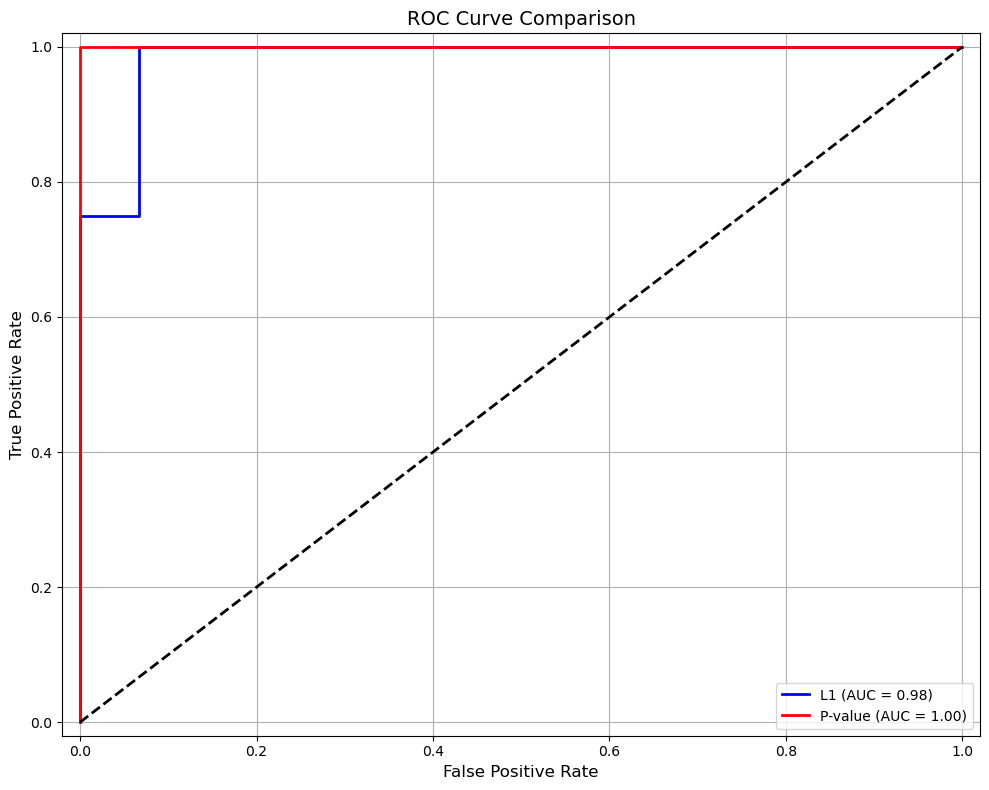


--- Conclusion ---
P-value based selection performs better in terms of AUC by 0.0167.

Implementation complexity:
L1-penalized regularization is generally easier to implement as it performs feature selection
and model fitting in one step. It also handles the perfect separation problem better.

P-value based selection requires multiple steps (RFE for feature selection, then model fitting)
and may face convergence issues with perfect separation in the data.


In [128]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

l = 4

column_name = list()
for i in range(1, l+1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(feature+"_"+str(series_name)+"_"+ str(i))
column_name.extend(["bending_label", "testing_label"])

important_feature = list()
important_feature.extend(important_feature_extraction("bending1", 7, 2, l))
important_feature.extend(important_feature_extraction("bending2", 6, 2, l))
for folder_name in other:
    important_feature.extend(important_feature_extraction(folder_name, 15, 3, l))

df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
df_important_feature.columns = column_name
df_important_feature = df_important_feature.apply(pd.to_numeric, errors='coerce')
df_important_feature = df_important_feature.fillna(0) 
df_important_feature["bending_label"] = df_important_feature["bending_label"].astype('int')
df_important_feature["testing_label"] = df_important_feature["testing_label"].astype('int')

df_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]
df_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]

X_train = df_train.iloc[:, :-2]
Y_train = df_train.iloc[:, -2]  
X_test = df_test.iloc[:, :-2]
Y_test = df_test.iloc[:, -2]

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

print("\n--- P-value based Selection ---")
start_time_p = time.time()

model_train = LogisticRegression(solver='liblinear', max_iter=1000)
rfe = RFE(model_train, n_features_to_select=5)
rfe.fit(X_train, Y_train)
cols = list(X_train.columns[rfe.support_])
print(f"Selected features by RFE: {cols}")

X_train_new = X_train[cols]
try:
    X_train_new = sm.add_constant(X_train_new)
    logit_model_selected = sm.Logit(Y_train, X_train_new)
    model_selected = logit_model_selected.fit(method='lbfgs', maxiter=1000)
    print(model_selected.summary())
    
    X_test_new = X_test[cols]
    X_test_new = sm.add_constant(X_test_new)
    p_pred = model_selected.predict(X_test_new) > 0.5
    p_prob = model_selected.predict(X_test_new)
    
except Exception as e:
    print(f"Error in statsmodels fitting: {e}")
    print("Using sklearn LogisticRegression instead")
    p_model = LogisticRegression(solver='liblinear', max_iter=1000)
    p_model.fit(X_train_new, Y_train)
    
    X_test_new = X_test[cols]
    p_pred = p_model.predict(X_test_new)
    p_prob = p_model.predict_proba(X_test_new)[:, 1]

p_accuracy = accuracy_score(Y_test, p_pred)
p_auc = roc_auc_score(Y_test, p_prob)
p_time = time.time() - start_time_p

p_conf_matrix = confusion_matrix(Y_test, p_pred)
print("\nConfusion Matrix (P-value method):")
print(p_conf_matrix)

print("\n--- L1-penalized Logistic Regression ---")
start_time_l1 = time.time()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

parameters = {'C': np.logspace(-3, 3, 7)} 

l1_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(l1_model, parameters, cv=5)
clf.fit(X_train_scaled, Y_train)

best_l1_model = clf.best_estimator_
best_C = clf.best_params_['C']

selected_features_l1 = X_train.columns[np.abs(best_l1_model.coef_[0]) > 0]
print(f"Number of features selected by L1: {len(selected_features_l1)}")
print(f"Selected features: {list(selected_features_l1)[:5]}...")
print(f"Best C value: {best_C}")

l1_pred = best_l1_model.predict(X_test_scaled)
l1_prob = best_l1_model.predict_proba(X_test_scaled)[:, 1]
l1_accuracy = accuracy_score(Y_test, l1_pred)
l1_auc = roc_auc_score(Y_test, l1_prob)
l1_time = time.time() - start_time_l1
l1_conf_matrix = confusion_matrix(Y_test, l1_pred)
print("\nConfusion Matrix (L1 method):")
print(l1_conf_matrix)

print("\n--- Comparison Summary ---")
print(f"{'Method':<20} {'Features':<10} {'Accuracy':<10} {'AUC':<10} {'Time (s)':<10}")
print("-" * 60)
print(f"{'L1 Regularization':<20} {len(selected_features_l1):<10} {l1_accuracy:.4f}    {l1_auc:.4f}    {l1_time:.2f}")
print(f"{'P-value Selection':<20} {len(cols):<10} {p_accuracy:.4f}    {p_auc:.4f}    {p_time:.2f}")

df_comparison = pd.DataFrame({
    "Method": ["L1 Regularization", "P-value Selection"],
    "Features": [len(selected_features_l1), len(cols)],
    "Accuracy": [l1_accuracy, p_accuracy],
    "AUC": [l1_auc, p_auc],
    "Time(s)": [l1_time, p_time]
})
print("\nComparison DataFrame:")
print(df_comparison.to_string(index=False))

plt.figure(figsize=(10, 8))
fpr_l1, tpr_l1, _ = roc_curve(Y_test, l1_prob)
plt.plot(fpr_l1, tpr_l1, 'b-', linewidth=2, label=f'L1 (AUC = {l1_auc:.2f})')
fpr_p, tpr_p, _ = roc_curve(Y_test, p_prob)
plt.plot(fpr_p, tpr_p, 'r-', linewidth=2, label=f'P-value (AUC = {p_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- Conclusion ---")
if l1_auc > p_auc:
    better_method = "L1-penalized regularization"
    diff = l1_auc - p_auc
elif p_auc > l1_auc:
    better_method = "P-value based selection"
    diff = p_auc - l1_auc
else:
    better_method = "Both methods"
    diff = 0

print(f"{better_method} performs better in terms of AUC by {diff:.4f}.")

print("\nImplementation complexity:")
print("L1-penalized regularization is generally easier to implement as it performs feature selection")
print("and model fitting in one step. It also handles the perfect separation problem better.")
print("\nP-value based selection requires multiple steps (RFE for feature selection, then model fitting)")
print("and may face convergence issues with perfect separation in the data.")

### (c) Multi-class Classification (The Realistic Case)
#### i. Find the best l in the same way as you found it in 2(b)i to build an L1- penalized multinomial regression model to classify all activities in your training set.10 Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.


Processing l = 1
At l = 1
Selected features: 18
C-value: 10.0
Best score: 0.8846153846153847

Processing l = 2
At l = 2
Selected features: 35
C-value: 10.0
Best score: 0.8846153846153847

Processing l = 3
At l = 3
Selected features: 30
C-value: 1.0
Best score: 0.856043956043956

Processing l = 4
At l = 4
Selected features: 40
C-value: 1.0
Best score: 0.8417582417582418

Processing l = 5
At l = 5
Selected features: 88
C-value: 10.0
Best score: 0.8395604395604396

Processing l = 6
At l = 6
Selected features: 49
C-value: 1.0
Best score: 0.8406593406593407

Processing l = 7
At l = 7
Selected features: 126
C-value: 100.0
Best score: 0.8406593406593406

Processing l = 8
At l = 8
Selected features: 144
C-value: 1000.0
Best score: 0.7967032967032968

Processing l = 9


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


At l = 9
Selected features: 162
C-value: 100.0
Best score: 0.8406593406593406

Processing l = 10


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


At l = 10
Selected features: 180
C-value: 1000.0
Best score: 0.8252747252747253

Processing l = 11


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


At l = 11
Selected features: 77
C-value: 1.0
Best score: 0.7538461538461538

Processing l = 12
At l = 12
Selected features: 91
C-value: 1.0
Best score: 0.7824175824175824

Processing l = 13
At l = 13
Selected features: 234
C-value: 100.0
Best score: 0.7813186813186812

Processing l = 14
At l = 14
Selected features: 84
C-value: 1.0
Best score: 0.8263736263736263

Processing l = 15


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


At l = 15
Selected features: 270
C-value: 100.0
Best score: 0.8109890109890111

Processing l = 16
At l = 16
Selected features: 107
C-value: 1.0
Best score: 0.8131868131868132

Processing l = 17
At l = 17
Selected features: 95
C-value: 1.0
Best score: 0.8406593406593406

Processing l = 18
At l = 18
Selected features: 109
C-value: 1.0
Best score: 0.8549450549450549

Processing l = 19


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


At l = 19
Selected features: 118
C-value: 1.0
Best score: 0.7824175824175824

Processing l = 20


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


At l = 20
Selected features: 113
C-value: 1.0
Best score: 0.8120879120879121
 l  p-features  C-value    Score
 1          18     10.0 0.884615
 2          35     10.0 0.884615
 3          30      1.0 0.856044
18         109      1.0 0.854945
 4          40      1.0 0.841758
 6          49      1.0 0.840659
 7         126    100.0 0.840659
 9         162    100.0 0.840659
17          95      1.0 0.840659
 5          88     10.0 0.839560
14          84      1.0 0.826374
10         180   1000.0 0.825275
16         107      1.0 0.813187
20         113      1.0 0.812088
15         270    100.0 0.810989
 8         144   1000.0 0.796703
12          91      1.0 0.782418
19         118      1.0 0.782418
13         234    100.0 0.781319
11          77      1.0 0.753846

Best l value: 1.0, Best C value: 10.0
Training set shape: (69, 18)
Testing set shape: (19, 18)
Test error: 0.0526
Test accuracy: 0.9474


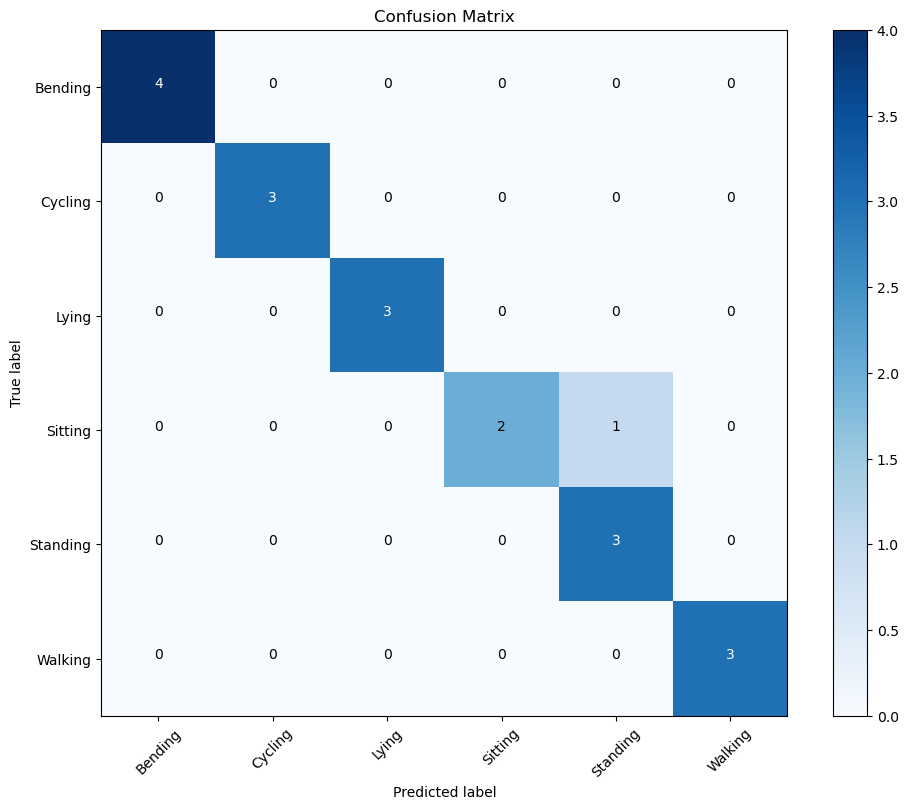

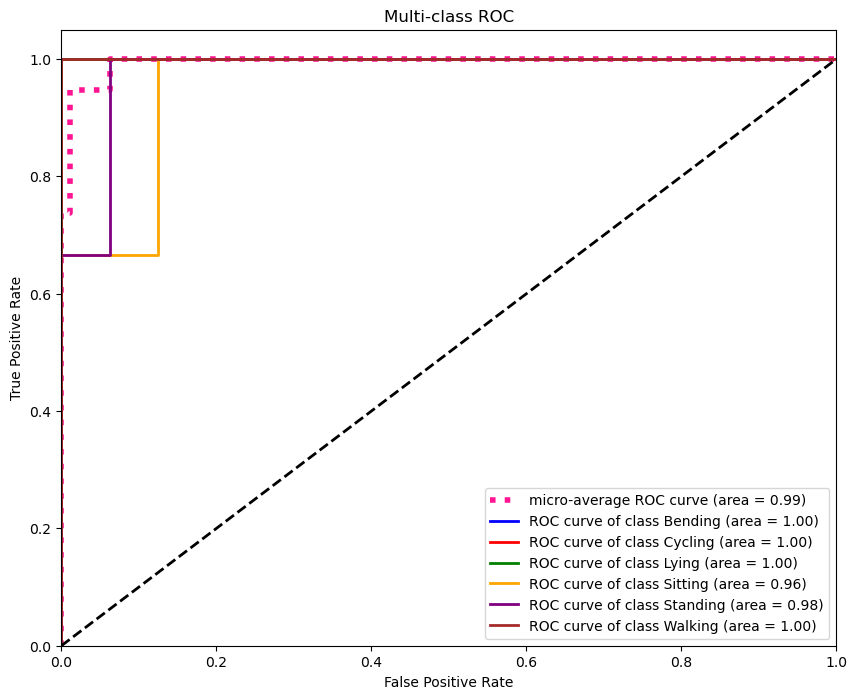


Classification Report:
              precision    recall  f1-score   support

     Bending       1.00      1.00      1.00         4
     Cycling       1.00      1.00      1.00         3
       Lying       1.00      1.00      1.00         3
     Sitting       1.00      0.67      0.80         3
    Standing       0.75      1.00      0.86         3
     Walking       1.00      1.00      1.00         3

    accuracy                           0.95        19
   macro avg       0.96      0.94      0.94        19
weighted avg       0.96      0.95      0.95        19



In [130]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

csv_header = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series_formatname = [i for i in range(1, 7)]

features = ['mean', '50%', 'std']
features_formatname = ['mean', 'median', 'std dev']

other = ["cycling", "lying", "sitting", "standing", "walking"]

def important_feature_extraction_multiclass(FolderName, num_csv, num_test, l, activity_label):
    train_csv = list()
    test_csv = list()
    for i in range(1, num_test+1):
        path = '../data/AReM/' + FolderName + "/dataset" + str(i) +".csv"
        test_csv.append(path)
    for i in range(num_test+1, num_csv+1):
        path = '../data/AReM/' + FolderName + "/dataset" + str(i) +".csv"
        train_csv.append(path)

    feature_extraction = list() 
    for filename in test_csv:
        try:
            df = pd.read_csv(filename, names=csv_header, skiprows=5)
            if 'time' in df.columns:
                df = df.drop("time", axis=1)  

            indices = np.array_split(df.index, l)
            df_split = [df.loc[idx] for idx in indices]

            split_info = list()  

            for df_sub in df_split:
                sub_df_info = list()  
                for series_name in series:
                    for feature in features:
                        value = df_sub[series_name].describe()[feature]
                        if pd.isna(value):
                            value = 0
                        sub_df_info.append(value)

                split_info.extend(sub_df_info)  

            split_info.append(activity_label)
            split_info.append(1)
            df_concat_info = pd.DataFrame([split_info])
            feature_extraction.append(df_concat_info)
        except Exception as e:
            print(f"Error processing test file {filename}: {e}")
        
    for filename in train_csv:
        try:
            df = pd.read_csv(filename, names=csv_header, skiprows=5)
            if 'time' in df.columns:
                df = df.drop("time", axis=1) 

            indices = np.array_split(df.index, l)
            df_split = [df.loc[idx] for idx in indices]

            split_info = list() 

            for df_sub in df_split:
                sub_df_info = list() 
                for series_name in series:
                    for feature in features:
                        value = df_sub[series_name].describe()[feature]
                        if pd.isna(value):
                            value = 0
                        sub_df_info.append(value)

                split_info.extend(sub_df_info) 

            split_info.append(activity_label)
            split_info.append(0)
            df_concat_info = pd.DataFrame([split_info])
            feature_extraction.append(df_concat_info)
        except Exception as e:
            print(f"Error processing train file {filename}: {e}")
    
    return feature_extraction

TimeSeries_size = [i for i in range(1, 21)]

plist = list()
score = list()
c_values = list()

for l in TimeSeries_size:
    print(f"\nProcessing l = {l}")
    column_name = list()
    for i in range(1, l+1):
        for series_name in series_formatname:
            for feature in features_formatname:
                column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

    column_name.extend(["activity_label", "testing_label"])
    
    important_feature = list()
    
    activity_mapping = {
        "bending1": 0, "bending2": 0, 
        "cycling": 1, "lying": 2, "sitting": 3, "standing": 4, "walking": 5
    }
    
    important_feature.extend(important_feature_extraction_multiclass("bending1", 7, 2, l, activity_mapping["bending1"]))
    important_feature.extend(important_feature_extraction_multiclass("bending2", 6, 2, l, activity_mapping["bending2"]))
    for folder_name in other:
        important_feature.extend(important_feature_extraction_multiclass(folder_name, 15, 3, l, activity_mapping[folder_name]))
        
    df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
    df_important_feature.columns = column_name
    df_important_feature = df_important_feature.apply(pd.to_numeric, errors='coerce')
    df_important_feature = df_important_feature.fillna(0)
    df_important_feature["activity_label"] = df_important_feature["activity_label"].astype('int')
    df_important_feature["testing_label"] = df_important_feature["testing_label"].astype('int')
    df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:, -2]
    
    scalar = StandardScaler()
    X_train_fit = scalar.fit_transform(X_train)

    try:
        parameters = {'C': np.logspace(-3, 3, 7)}
        mod_lr = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=5000)
        clf = GridSearchCV(mod_lr, parameters, cv=5)
        clf.fit(X_train_fit, Y_train)

        sel_ = SelectFromModel(LogisticRegression(C=clf.best_params_['C'], penalty='l1', solver='saga', 
                                                multi_class='multinomial', max_iter=5000))
        sel_.fit(X_train_fit, Y_train)
    
        selected_feat = X_train.columns[sel_.get_support()]
        plist.append(len(selected_feat))
        score.append(clf.best_score_)
        c_values.append(clf.best_params_['C'])
        
        print(f"At l = {l}")
        print(f"Selected features: {len(selected_feat)}")
        print(f"C-value: {clf.best_params_['C']}")
        print(f"Best score: {clf.best_score_}")
    except Exception as e:
        print(f"Error at l={l}: {e}")
        plist.append(0)
        score.append(0)
        c_values.append(0)

df_bestp = pd.DataFrame({"l": TimeSeries_size, "p-features": plist, "C-value": c_values, "Score": score})
df_bestp.index = np.arange(1, 21)
df_bestp = df_bestp.sort_values(by=["Score", "l"], ascending=[False, True])
print(df_bestp.to_string(index=False))

best_l = df_bestp.iloc[0]['l']
best_c = df_bestp.iloc[0]['C-value']
print(f"\nBest l value: {best_l}, Best C value: {best_c}")

column_name = list()
for i in range(1, int(best_l)+1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

column_name.extend(["activity_label", "testing_label"])

important_feature = list()
activity_mapping = {
    "bending1": 0, "bending2": 0, 
    "cycling": 1, "lying": 2, "sitting": 3, "standing": 4, "walking": 5
}

important_feature.extend(important_feature_extraction_multiclass("bending1", 7, 2, int(best_l), activity_mapping["bending1"]))
important_feature.extend(important_feature_extraction_multiclass("bending2", 6, 2, int(best_l), activity_mapping["bending2"]))
for folder_name in other:
    important_feature.extend(important_feature_extraction_multiclass(folder_name, 15, 3, int(best_l), activity_mapping[folder_name]))
    
df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
df_important_feature.columns = column_name
df_important_feature = df_important_feature.apply(pd.to_numeric, errors='coerce')
df_important_feature = df_important_feature.fillna(0)
df_important_feature["activity_label"] = df_important_feature["activity_label"].astype('int')
df_important_feature["testing_label"] = df_important_feature["testing_label"].astype('int')

df_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]
df_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]

X_train = df_train.iloc[:, :-2]
Y_train = df_train.iloc[:, -2]
X_test = df_test.iloc[:, :-2]
Y_test = df_test.iloc[:, -2]

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_model = LogisticRegression(C=best_c, penalty='l1', solver='saga', multi_class='multinomial', max_iter=5000)
best_model.fit(X_train_scaled, Y_train)

Y_pred = best_model.predict(X_test_scaled)
test_error = 1 - accuracy_score(Y_test, Y_pred)
print(f"Test error: {test_error:.4f}")
print(f"Test accuracy: {accuracy_score(Y_test, Y_pred):.4f}")

cm = confusion_matrix(Y_test, Y_pred)
activity_names = ['Bending', 'Cycling', 'Lying', 'Sitting', 'Standing', 'Walking']

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(activity_names))
plt.xticks(tick_marks, activity_names, rotation=45)
plt.yticks(tick_marks, activity_names)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Y_test_bin = label_binarize(Y_test, classes=np.unique(np.concatenate([Y_train.unique(), Y_test.unique()])))
n_classes = Y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

Y_score = best_model.predict_proba(X_test_scaled)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {activity_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred, target_names=activity_names))

#### ii. Repeat 2(c)i using a Naive Bayes’ classifier. Use both Gaussian and Multi-nomial priors and compare the results.


Processing l = 1
Gaussian NB Score at l=1: 0.8421
Multinomial NB Score at l=1: 0.8421

Processing l = 2
Gaussian NB Score at l=2: 0.8421
Multinomial NB Score at l=2: 0.8421

Processing l = 3
Gaussian NB Score at l=3: 0.8947
Multinomial NB Score at l=3: 0.8421

Processing l = 4
Gaussian NB Score at l=4: 0.8947
Multinomial NB Score at l=4: 0.8421

Processing l = 5
Gaussian NB Score at l=5: 0.8947
Multinomial NB Score at l=5: 0.8421

Processing l = 6
Gaussian NB Score at l=6: 0.8947
Multinomial NB Score at l=6: 0.8947

Processing l = 7
Gaussian NB Score at l=7: 0.8421
Multinomial NB Score at l=7: 0.8947

Processing l = 8
Gaussian NB Score at l=8: 0.8421
Multinomial NB Score at l=8: 0.8947

Processing l = 9
Gaussian NB Score at l=9: 0.8421
Multinomial NB Score at l=9: 0.8947

Processing l = 10
Gaussian NB Score at l=10: 0.8947
Multinomial NB Score at l=10: 0.9474

Processing l = 11
Gaussian NB Score at l=11: 0.8421
Multinomial NB Score at l=11: 0.9474

Processing l = 12
Gaussian NB Score 

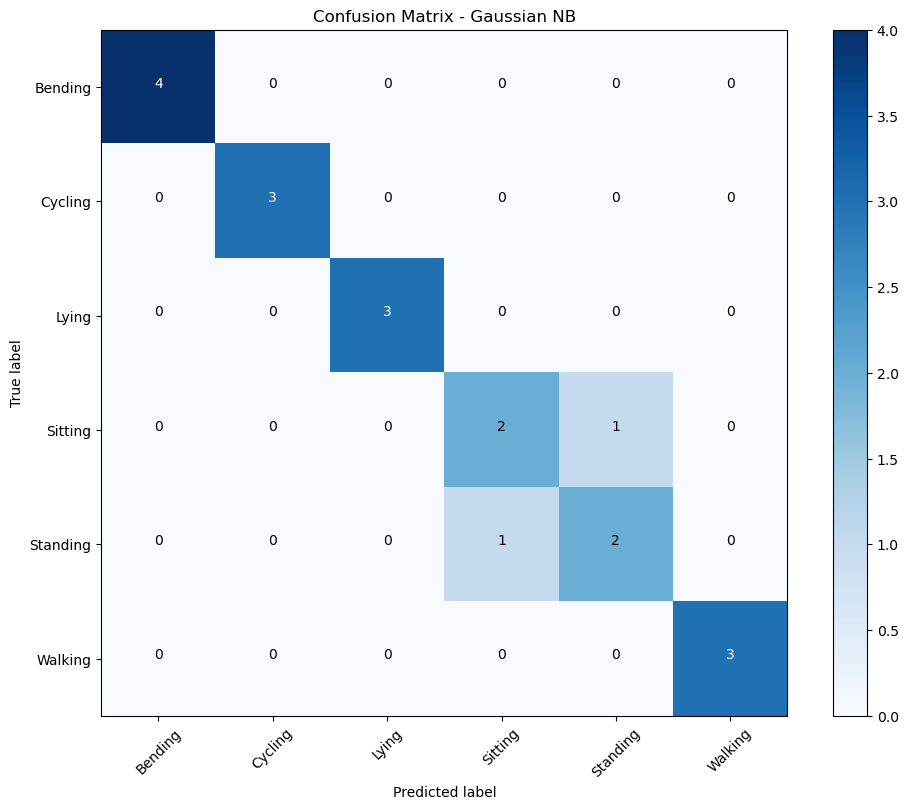

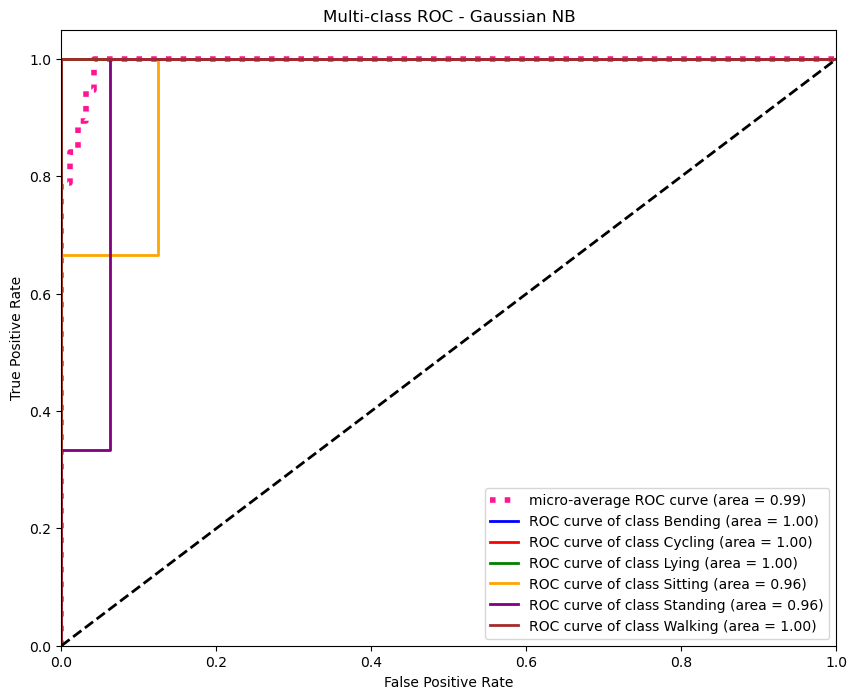


Classification Report - Gaussian NB:
              precision    recall  f1-score   support

     Bending       1.00      1.00      1.00         4
     Cycling       1.00      1.00      1.00         3
       Lying       1.00      1.00      1.00         3
     Sitting       0.67      0.67      0.67         3
    Standing       0.67      0.67      0.67         3
     Walking       1.00      1.00      1.00         3

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19


===== Final Multinomial NB Model =====
Training set shape: (69, 180)
Testing set shape: (19, 180)
Test error: 0.0526
Test accuracy: 0.9474


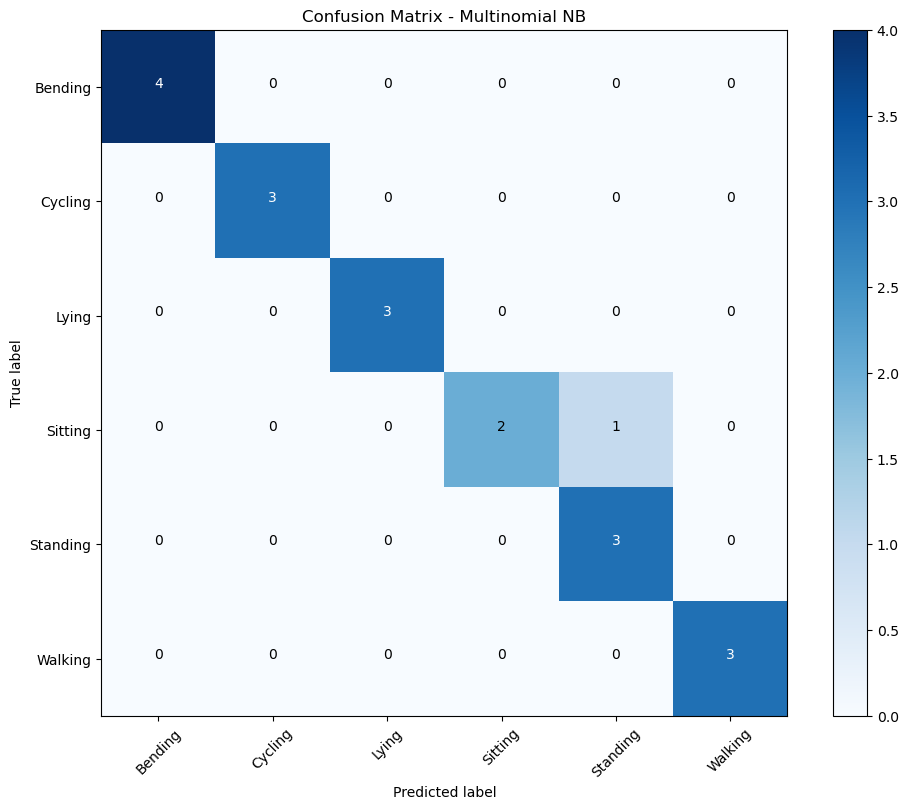

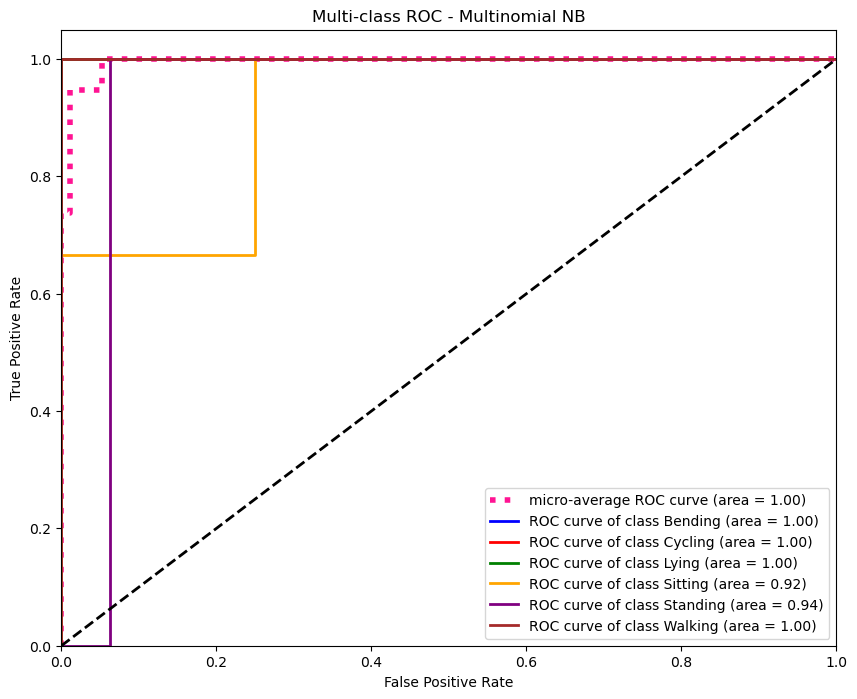


Classification Report - Multinomial NB:
              precision    recall  f1-score   support

     Bending       1.00      1.00      1.00         4
     Cycling       1.00      1.00      1.00         3
       Lying       1.00      1.00      1.00         3
     Sitting       1.00      0.67      0.80         3
    Standing       0.75      1.00      0.86         3
     Walking       1.00      1.00      1.00         3

    accuracy                           0.95        19
   macro avg       0.96      0.94      0.94        19
weighted avg       0.96      0.95      0.95        19


===== Model Comparison Summary =====
Gaussian NB Test Accuracy: 0.8947
Multinomial NB Test Accuracy: 0.9474


In [132]:
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")

csv_header = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series_formatname = [i for i in range(1, 7)]

features = ['mean', '50%', 'std']
features_formatname = ['mean', 'median', 'std dev']
other = ["cycling", "lying", "sitting", "standing", "walking"]

def important_feature_extraction_multiclass(FolderName, num_csv, num_test, l, activity_label):
    train_csv = list()
    test_csv = list()

    for i in range(1, num_test+1):
        path = '../data/AReM/' + FolderName + "/dataset" + str(i) +".csv"
        test_csv.append(path)
    for i in range(num_test+1, num_csv+1):
        path = '../data/AReM/' + FolderName + "/dataset" + str(i) +".csv"
        train_csv.append(path)

    feature_extraction = list() 
    for filename in test_csv:
        try:
            df = pd.read_csv(filename, names=csv_header, skiprows=5)
            if 'time' in df.columns:
                df = df.drop("time", axis=1)  
            indices = np.array_split(df.index, l)
            df_split = [df.loc[idx] for idx in indices]

            split_info = list()  

            for df_sub in df_split:
                sub_df_info = list() 
                for series_name in series:
                    for feature in features:
                        value = df_sub[series_name].describe()[feature]
                        if pd.isna(value):
                            value = 0
                        sub_df_info.append(value)

                split_info.extend(sub_df_info) 

            split_info.append(activity_label)
            split_info.append(1)
            df_concat_info = pd.DataFrame([split_info])
            feature_extraction.append(df_concat_info)
        except Exception as e:
            print(f"Error processing test file {filename}: {e}")
        
    for filename in train_csv:
        try:
            df = pd.read_csv(filename, names=csv_header, skiprows=5)
            if 'time' in df.columns:
                df = df.drop("time", axis=1)  

            indices = np.array_split(df.index, l)
            df_split = [df.loc[idx] for idx in indices]

            split_info = list() 

            for df_sub in df_split:
                sub_df_info = list() 
                for series_name in series:
                    for feature in features:
                        value = df_sub[series_name].describe()[feature]
                        if pd.isna(value):
                            value = 0
                        sub_df_info.append(value)

                split_info.extend(sub_df_info)  

            split_info.append(activity_label)
            split_info.append(0)
            df_concat_info = pd.DataFrame([split_info])
            feature_extraction.append(df_concat_info)
        except Exception as e:
            print(f"Error processing train file {filename}: {e}")
    
    return feature_extraction

TimeSeries_size = [i for i in range(1, 21)]

gaussian_scores = []
multinomial_scores = []

for l in TimeSeries_size:
    print(f"\nProcessing l = {l}")
    column_name = list()
    for i in range(1, l+1):
        for series_name in series_formatname:
            for feature in features_formatname:
                column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

    column_name.extend(["activity_label", "testing_label"])
    
    important_feature = list()
    activity_mapping = {
        "bending1": 0, "bending2": 0,  
        "cycling": 1, "lying": 2, "sitting": 3, "standing": 4, "walking": 5
    }
    
    important_feature.extend(important_feature_extraction_multiclass("bending1", 7, 2, l, activity_mapping["bending1"]))
    important_feature.extend(important_feature_extraction_multiclass("bending2", 6, 2, l, activity_mapping["bending2"]))
    for folder_name in other:
        important_feature.extend(important_feature_extraction_multiclass(folder_name, 15, 3, l, activity_mapping[folder_name]))
        
    df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
    df_important_feature.columns = column_name
    df_important_feature = df_important_feature.apply(pd.to_numeric, errors='coerce')
    df_important_feature = df_important_feature.fillna(0)
    df_important_feature["activity_label"] = df_important_feature["activity_label"].astype('int')
    df_important_feature["testing_label"] = df_important_feature["testing_label"].astype('int')

    df_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]
    df_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]

    X_train = df_train.iloc[:, :-2]
    Y_train = df_train.iloc[:, -2]
    X_test = df_test.iloc[:, :-2]
    Y_test = df_test.iloc[:, -2]
    
    try:
        gnb = GaussianNB()
        gnb.fit(X_train, Y_train)
        gnb_score = gnb.score(X_test, Y_test)
        gaussian_scores.append(gnb_score)
        print(f"Gaussian NB Score at l={l}: {gnb_score:.4f}")
    except Exception as e:
        print(f"Error with Gaussian NB at l={l}: {e}")
        gaussian_scores.append(0)

    try:
        min_val = X_train.min().min()
        if min_val < 0:
            X_train_shifted = X_train - min_val
            X_test_shifted = X_test - min_val
        else:
            X_train_shifted = X_train
            X_test_shifted = X_test
        
        mnb = MultinomialNB(alpha=0.1)
        mnb.fit(X_train_shifted, Y_train)
        mnb_score = mnb.score(X_test_shifted, Y_test)
        multinomial_scores.append(mnb_score)
        print(f"Multinomial NB Score at l={l}: {mnb_score:.4f}")
    except Exception as e:
        print(f"Error with Multinomial NB at l={l}: {e}")
        multinomial_scores.append(0)

df_comparison = pd.DataFrame({
    "l": TimeSeries_size,
    "Gaussian NB Score": gaussian_scores,
    "Multinomial NB Score": multinomial_scores
})

best_gaussian_idx = np.argmax(gaussian_scores)
best_multinomial_idx = np.argmax(multinomial_scores)

best_gaussian_l = TimeSeries_size[best_gaussian_idx]
best_multinomial_l = TimeSeries_size[best_multinomial_idx]

print("\n===== Model Comparison =====")
print(df_comparison)
print(f"\nBest l for Gaussian NB: {best_gaussian_l} with score: {gaussian_scores[best_gaussian_idx]:.4f}")
print(f"Best l for Multinomial NB: {best_multinomial_l} with score: {multinomial_scores[best_multinomial_idx]:.4f}")


print("\n===== Final Gaussian NB Model =====")
column_name = list()
for i in range(1, int(best_gaussian_l)+1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

column_name.extend(["activity_label", "testing_label"])

important_feature = list()
important_feature.extend(important_feature_extraction_multiclass("bending1", 7, 2, int(best_gaussian_l), activity_mapping["bending1"]))
important_feature.extend(important_feature_extraction_multiclass("bending2", 6, 2, int(best_gaussian_l), activity_mapping["bending2"]))
for folder_name in other:
    important_feature.extend(important_feature_extraction_multiclass(folder_name, 15, 3, int(best_gaussian_l), activity_mapping[folder_name]))
    
df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
df_important_feature.columns = column_name
df_important_feature = df_important_feature.apply(pd.to_numeric, errors='coerce')
df_important_feature = df_important_feature.fillna(0)
df_important_feature["activity_label"] = df_important_feature["activity_label"].astype('int')
df_important_feature["testing_label"] = df_important_feature["testing_label"].astype('int')

df_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]
df_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]

X_train = df_train.iloc[:, :-2]
Y_train = df_train.iloc[:, -2]
X_test = df_test.iloc[:, :-2]
Y_test = df_test.iloc[:, -2]

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

gnb_model = GaussianNB()
gnb_model.fit(X_train, Y_train)

Y_pred_gnb = gnb_model.predict(X_test)
test_error_gnb = 1 - accuracy_score(Y_test, Y_pred_gnb)
print(f"Test error: {test_error_gnb:.4f}")
print(f"Test accuracy: {accuracy_score(Y_test, Y_pred_gnb):.4f}")

cm_gnb = confusion_matrix(Y_test, Y_pred_gnb)
activity_names = ['Bending', 'Cycling', 'Lying', 'Sitting', 'Standing', 'Walking']

plt.figure(figsize=(10, 8))
plt.imshow(cm_gnb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Gaussian NB')
plt.colorbar()
tick_marks = np.arange(len(activity_names))
plt.xticks(tick_marks, activity_names, rotation=45)
plt.yticks(tick_marks, activity_names)

thresh = cm_gnb.max() / 2
for i in range(cm_gnb.shape[0]):
    for j in range(cm_gnb.shape[1]):
        plt.text(j, i, format(cm_gnb[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_gnb[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Y_test_bin = label_binarize(Y_test, classes=np.unique(np.concatenate([Y_train.unique(), Y_test.unique()])))
n_classes = Y_test_bin.shape[1]

fpr_gnb = dict()
tpr_gnb = dict()
roc_auc_gnb = dict()

Y_score_gnb = gnb_model.predict_proba(X_test)

for i in range(n_classes):
    fpr_gnb[i], tpr_gnb[i], _ = roc_curve(Y_test_bin[:, i], Y_score_gnb[:, i])
    roc_auc_gnb[i] = auc(fpr_gnb[i], tpr_gnb[i])

fpr_gnb["micro"], tpr_gnb["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_score_gnb.ravel())
roc_auc_gnb["micro"] = auc(fpr_gnb["micro"], tpr_gnb["micro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr_gnb["micro"], tpr_gnb["micro"],
         label=f'micro-average ROC curve (area = {roc_auc_gnb["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_gnb[i], tpr_gnb[i], color=color, lw=2,
             label=f'ROC curve of class {activity_names[i]} (area = {roc_auc_gnb[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC - Gaussian NB')
plt.legend(loc="lower right")
plt.show()

print("\nClassification Report - Gaussian NB:")
print(classification_report(Y_test, Y_pred_gnb, target_names=activity_names))

print("\n===== Final Multinomial NB Model =====")
column_name = list()
for i in range(1, int(best_multinomial_l)+1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

column_name.extend(["activity_label", "testing_label"])

important_feature = list()
important_feature.extend(important_feature_extraction_multiclass("bending1", 7, 2, int(best_multinomial_l), activity_mapping["bending1"]))
important_feature.extend(important_feature_extraction_multiclass("bending2", 6, 2, int(best_multinomial_l), activity_mapping["bending2"]))
for folder_name in other:
    important_feature.extend(important_feature_extraction_multiclass(folder_name, 15, 3, int(best_multinomial_l), activity_mapping[folder_name]))

df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
df_important_feature.columns = column_name
df_important_feature = df_important_feature.apply(pd.to_numeric, errors='coerce')
df_important_feature = df_important_feature.fillna(0)
df_important_feature["activity_label"] = df_important_feature["activity_label"].astype('int')
df_important_feature["testing_label"] = df_important_feature["testing_label"].astype('int')

df_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]
df_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]

X_train = df_train.iloc[:, :-2]
Y_train = df_train.iloc[:, -2]
X_test = df_test.iloc[:, :-2]
Y_test = df_test.iloc[:, -2]

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

min_val = X_train.min().min()
if min_val < 0:
    X_train_shifted = X_train - min_val
    X_test_shifted = X_test - min_val
else:
    X_train_shifted = X_train
    X_test_shifted = X_test

mnb_model = MultinomialNB(alpha=0.1)
mnb_model.fit(X_train_shifted, Y_train)

Y_pred_mnb = mnb_model.predict(X_test_shifted)
test_error_mnb = 1 - accuracy_score(Y_test, Y_pred_mnb)
print(f"Test error: {test_error_mnb:.4f}")
print(f"Test accuracy: {accuracy_score(Y_test, Y_pred_mnb):.4f}")
cm_mnb = confusion_matrix(Y_test, Y_pred_mnb)

plt.figure(figsize=(10, 8))
plt.imshow(cm_mnb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Multinomial NB')
plt.colorbar()
tick_marks = np.arange(len(activity_names))
plt.xticks(tick_marks, activity_names, rotation=45)
plt.yticks(tick_marks, activity_names)

thresh = cm_mnb.max() / 2
for i in range(cm_mnb.shape[0]):
    for j in range(cm_mnb.shape[1]):
        plt.text(j, i, format(cm_mnb[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_mnb[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

fpr_mnb = dict()
tpr_mnb = dict()
roc_auc_mnb = dict()

Y_score_mnb = mnb_model.predict_proba(X_test_shifted)

for i in range(n_classes):
    fpr_mnb[i], tpr_mnb[i], _ = roc_curve(Y_test_bin[:, i], Y_score_mnb[:, i])
    roc_auc_mnb[i] = auc(fpr_mnb[i], tpr_mnb[i])

fpr_mnb["micro"], tpr_mnb["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_score_mnb.ravel())
roc_auc_mnb["micro"] = auc(fpr_mnb["micro"], tpr_mnb["micro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr_mnb["micro"], tpr_mnb["micro"],
         label=f'micro-average ROC curve (area = {roc_auc_mnb["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_mnb[i], tpr_mnb[i], color=color, lw=2,
             label=f'ROC curve of class {activity_names[i]} (area = {roc_auc_mnb[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC - Multinomial NB')
plt.legend(loc="lower right")
plt.show()
print("\nClassification Report - Multinomial NB:")
print(classification_report(Y_test, Y_pred_mnb, target_names=activity_names))

print("\n===== Model Comparison Summary =====")
print(f"Gaussian NB Test Accuracy: {accuracy_score(Y_test, Y_pred_gnb):.4f}")
print(f"Multinomial NB Test Accuracy: {accuracy_score(Y_test, Y_pred_mnb):.4f}")

#### iii. Which method is better for multi-class classification in this problem?
From the above results, it is clear that Multinomial priors gives better results.

## References
#### https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 
#### https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-classification
#### https://towardsdatascience.com/understanding-confusion-matrix-python-7df3ae35f3a7
#### https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
#### https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
#### https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data
